<a href="https://colab.research.google.com/github/israelsastre/prediccion_combates_pokemon/blob/main/PROYECTO_POKEMONS_PREDICCI%C3%93N_COMBATES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.EXPLICACIÓN DEL PROYECTO

Este proyecto está basado en el Dataset de Kaggle:
https://www.kaggle.com/shubhamchambhare/pokemons-and-there-stats

Creado por https://www.kaggle.com/shubhamchambhare

Es un Dataset **con 1045 Pokemons** y sus características: *nombre, total, ataque, defensa, puntos de golpe, velocidad, ataque especial y defensa especial*

La idea es crear un modelo predictivo para saber quién sería el ganador en una pelea entre dos Pokemons.

Para ello he realizado los siguientes procesos:

1- Transformación de datos originales añadiendo una característica más: Categoría, basado en la puntuación de la columna 'Total' del dataset.

2- Creación de una clase llamada Fight. Esta clase recibe el número de índice de 2 pokemons del dataset y nos devuelve el resultado del combate.

  * Las reglas del combate no son las establecidas en el juego de cartas, sino que me he creado un sistema basado en las estadísticas proporcionadas por la base de datos, además de un componente aleatorio en relación a los porcentajes de daños de los ataques y de bloqueo de la defensa además de porcentajes de probabilidad de que ocurran atques y defensas especiales **(explicación detallada en el apartado 2.5)**.
  * El objeto resultado tiene las diferencias cuantitativas entre los valores de cada Pokemon y el ganador del combate. Otro paralelo tiene los mismos datos y las estadísticas aleatorias generadas **(explicación detallada en el apartado 2.5)**.

3- Ese objeto es el que usaremos para crear nuestro modelo de ML, para ello creamos un dataset con un bucle que generará 186.750 enfrentamientos. Ese Dataset lo dividiremos en uno con el 60% de los enfrentamientos para entrenar y predecir los modelos y el 40% restante lo dejaremos sin tocar para evaluar los 3 mejores modelos **más información en apartados 2.6 y 2.7**. Esto nos deja un problema de clasificación binaria de aprendizaje supervisado.

4- Realizaremos pruebas con diferentes modelos y ensembles

5- Evaluaremos los modelos en función de varios conceptos y seleccionaremos los 3 mejores.

6- Con los 3 mejores volveremos a hacer fitting con todo el set de entrenamiento del 60% y lo validaremos de dos maneras:
  * Obtendremos la accuracy del modelo para el 40% de los combates no vistos
  * Haremos CrossValidation con el dataset del 40% 
  * El modelo ganador será el que obtenga la mejor media entre ambos valores

7- Con el modelo ganador haremos un **fitting con toda la base de datos**. Simularemos una puesta en producción con una pequeña interface a través de un formulario. 

En este formulario también simularemos como si el propio modelo aprendiera con los nuevos combates de tal manera que cada 30 combates realiza dos acciones:
  * Monitoriza con esos nuevos combates si el modelo sigue manteniendo buenas predicciones, sino lanza un aviso.
  * Hace un fitting al modelo con el dataset completo y las nuevas 30 predicciones.

Además hay dos apéndices finales

Appendix 1: Permite hacer el tunning y el evaluado de todos los modelos de una vez

Appendix 2: Usando el modelo ganador, realiza las predicciones con el dataset que incluye las estadísticas aleatorias generadas en el combate. Aunque estas estadísticas son imposibles de conocer apriori, es un buen ejercicio para observar **la importancia de la aleatoriedad** en el performance del modelo.

**IMPORTANTE**

**Los modelos y tunnig usados son mi elección. Entiendo que pueda haber otas opciones. Mi mejor resultado es 88.64% de accuracy. Si alguien quiere probar y encontrar mejores precisiones es bienvenido. En los repositorios dejo las bases de datos creadas para evitar tener que crearlas, además de así poder trabajar con los mismos datos**

**NOTA**
*Muchas de los nombres de las variables están en español ya que inicialmente es el idioma en el que lo realicé y cambiarlas todas pensando que no va a haber un problema en algún momento determinado es demasiado optimista. Es por ello que he traducido los textos y las impresiones, pero no los nombres de variables, columnas e índices. Espero que se entienda*

Gracias por el tiempo dedicado


# 2.CREACIÓN DE LA BASE DE DATOS

### 2.1 Importamos las librerías



In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import random 
from statistics import mean, stdev
import statistics
import time
import io
%matplotlib inline

### 2.2 Cargamos la base de datos de Pokemons


In [ ]:
# cargamos la base de datos creada por  https://www.kaggle.com/shubhamchambhare
from google.colab import files
uploaded = files.upload()

Saving pokemon.csv to pokemon.csv


In [ ]:
df = pd.read_csv(io.StringIO(uploaded['pokemon.csv'].decode('utf-8')))

### 2.3 EDA

In [ ]:
#Echamos un primer vistazo a la base de datos de los Pokemons
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        1045 non-null   object
 1   Total       1045 non-null   int64 
 2   HP          1045 non-null   int64 
 3   Attack      1045 non-null   int64 
 4   Defence     1045 non-null   int64 
 5   Sp_attack   1045 non-null   int64 
 6   Sp_defence  1045 non-null   int64 
 7   Speed       1045 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 65.4+ KB


Podemos ver que no hay valores nulos.
Hay 1045 Pokemons y todas las características son numéricas excepto el nombre.

Vamos a mirar ahora a los primeros 3 Pokemons para ver cómo son los valores y comprobar si hay duplicados para la creación de nuestra base de datos de combates.

In [ ]:
df.head(3)

,Name,Total,HP,Attack,Defence,Sp_attack,Sp_defence,Speed
0,Bulbasaur,318,45,49,49,65,65,45
1,Ivysaur,405,60,62,63,80,80,60
2,Venusaur,525,80,82,83,100,100,80


In [ ]:

df[df.duplicated()==True]

,Name,Total,HP,Attack,Defence,Sp_attack,Sp_defence,Speed
421,Mega Castform X,420,70,70,70,70,70,70
572,Mega Rotom X,520,50,65,107,105,107,86
573,Mega Rotom X,520,50,65,107,105,107,86
574,Mega Rotom X,520,50,65,107,105,107,86
869,Mega Oricorio X,476,75,70,70,98,70,93


### 2.4 Transformación de datos

In [ ]:
# Quitamos los valores duplicados
df = df.drop_duplicates(['Name'], keep='last')
df.reset_index(drop=True, inplace=True)

In [ ]:
#Creamos la variable 'Categoría' según el Total. Lo dividimos en 6 categorías con igual proporción de Pokemon en cada una.

quantiles = np.linspace(0,1,7)

bins = df['Total'].quantile(quantiles)
bins = bins.values

names = [1, 2, 3, 4, 5 , 6]

df['Categoria'] = pd.cut(df['Total'], bins=bins, labels=names)

df.head(3)

,Name,Total,HP,Attack,Defence,Sp_attack,Sp_defence,Speed,Categoria
0,Bulbasaur,318,45,49,49,65,65,45,2
1,Ivysaur,405,60,62,63,80,80,60,3
2,Venusaur,525,80,82,83,100,100,80,5


In [ ]:
#Comprobamos si están equitativamente distribuidas las categortías
df.groupby(by='Categoria').count()

,Name,Total,HP,Attack,Defence,Sp_attack,Sp_defence,Speed
Categoria,,,,,,,,
1,182,182,182,182,182,182,182,182
2,162,162,162,162,162,162,162,162
3,173,173,173,173,173,173,173,173
4,180,180,180,180,180,180,180,180
5,167,167,167,167,167,167,167,167
6,170,170,170,170,170,170,170,170


In [ ]:
#Este Dataset estará disponible como recurso pero este comando permite guardarlo en local

df.to_csv('df_pokemons.csv', index=False)

### 2.5 Creamos la Clase Fight:
  
  *Esta clase es la que entrega un objeto de combate entre dos pokemons, comparable para la creación de un modelo de ML y otro con las estadísticas asociadas a cada combate para un posterior análisis si se desea*

El primer objeto tiene las siguientes características:

>  
* Diferencia entre valores de ataque de ambos pokemons
* Diferencia entre valores de defensa de ambos pokemons
* Diferencia entre valores de ataque especial de ambos pokemons
* Diferencia entre valores de defensa especial de ambos pokemons
* El Pokemon que ataca primero en clase binaria (0/1) 
* Diferencia entre valores de categoría de ambos pokemons
* Ganador del combate (0/1)


El segundo objeto es el mismo solo que añadiendo las estadísticas asociadas del combate: medias de % de daño de ataque y bloqueo de defensa y cuantas veces se ha producido un ataque o una defensa especial.

El ganador del combate se obtiene tras aplicar diferentes porcentajes a las características de los pokemons**. Las reglas del combate son:

> * Los % de daño de ataque y bloqueo de defensa estarán siempre en un valor comprendido entre el 50 y el 100% del valor de base
* Hay un 20% de posibilidades de que se produzca un ataque especial o una defensa especial
* Si se produce un ataque especial, los valores del daño y la defensa especial estarán comprendidos entre el 30 y el 100% del valor base.
* Asumimos que hay un ataque por turno y empieza el de mayor velocidad. A igual velocidad se aplicará en cada turno un valor aleatorio del 50% para ver quién empieza.
* Tras cada ataque se chequea la vida del pokemon oponente. si sigue con vida será su turno de contraataque, si no se devuelve el objeto resultado.

Estos cálculos se realizan en las funciones implícitas de la clase:


> * Función Combate: Es la función principal basada en un bucle infinito que para cuando uno de los Pokemons llega a 0 o menos vida. Es la que llama al resto de funciones para obtener resultados o devolver el objeto final
  * Función enfrentamiento: Es la encargada dentro de la función de combate de calcular el daño que se produce en cada turno por cada pokemon. Devuelve el daño los porcentajes y agregados de cada enfrentamiento.
  * Función calcular_vida: Se encarga de evaluar la cantidad de vida que queda al pokemon que defiende después de aplicar el daño
  * agregar: Es la función final que devuelve un objeto con los valores acumulados del combate


** *La forma de realizar los combates es inventada y no tienen nada que ver con la forma de jugar a las cartas de pokemons, es simplemente un formato inventado a efectos de crear una base de datos sobre la que trabajar.*

In [ ]:
class Fight:


    def __init__(self):
      self.turno = 1
## ESTA ES LA PRINCIPAL FUNCIÓN, LA QUE EJCUTA TODO Y RECIBE COMO VALORES LOS ÍNDICES DE 2 POKEMON

    def combate (self, pok1, pok2):
      self.pokemons = df.iloc[[pok1, pok2]][['Attack','Defence','Sp_attack', 'Sp_defence', 'Name']]
      self.vida = [df.iloc[pok1]['HP'],df.iloc[pok2]['HP']]
      self.velocidad = [df.iloc[pok1]['Speed'],df.iloc[pok2]['Speed']]
      self.estadisticas = pd.DataFrame(columns= ['porc_atac_pok1', 'porc_atac_pok2', 'porc_def_pok1', 
                                                 'porc_def_pok2','atac_esp_pok1', 'atac_esp_pok2', 
                                                 'def_esp_pok1', 'def_esp_pok2'])
      self.resultado = []
      self.pok1 = pok1
      self.pok2 = pok2

## ESTA FUNCION NOS CALCULA LOS ENFRENTAMIENTOS INDIVIDUALES DE CADA TURNO (INCLUIDA EN COMBATE)
      def enfrentamiento (atacante, defensor, pokemons):
        porc_atac = random.uniform(0.5,1)
        porc_defensa = random.uniform(0.5,1)
        probab_esp_atac = random.random()
        porc_atac_esp = random.uniform(0.3,1)
        probab_esp_def = random.random()
        porc_defensa_esp = random.uniform(0.3,1)
        atac_esp = 0
        def_esp = 0
        est_enfrent = []

        if probab_esp_atac <=0.20:
          daño = round((pokemons.iloc[atacante]['Attack']*porc_atac - pokemons.iloc[defensor]['Defence']*porc_defensa) + (porc_atac_esp*pokemons.iloc[atacante]['Sp_attack']), 2)
          atac_esp = 1
        else:
          daño =  round((pokemons.iloc[atacante]['Attack']*porc_atac - pokemons.iloc[defensor]['Defence']*porc_defensa), 2)
        
        if probab_esp_def <=0.20:
          daño = daño - round((pokemons.iloc[defensor]['Sp_defence']*porc_defensa_esp),2)
          def_esp = 1
    
        est_enfrent = [porc_atac, porc_defensa, atac_esp, def_esp]
        return daño, est_enfrent


#################################################################################

## ESTA SEGUNDA FUNCIÓN CALCULA CUANTA VIDA LE QUEDA AL POKEMON QUE SE HA DEFENDIDO (INCLUIDA EN COMBATE)

      def calcularvida (daño, vida, atacante, defensor, pokemons):
        if daño >=0:
          vida[defensor] = round(vida[defensor] - daño,2)
             
        return vida[defensor]

###################################################################################

## CON ESTA FUNCIÓN CREAMOS EL OBJETO QUE IRÁ A LA BASE DE DATOS DE LAS BATALLAS DE POKEMONS (INCLUIDA EN COMBATE)

      def agregar (pok1, pok2, dif_vel, ganador, estadisticas):
        dif_atac = df.iloc[pok1]['Attack']-df.iloc[pok2]['Attack']
        dif_def = df.iloc[pok1]['Defence']-df.iloc[pok2]['Defence']
        dif_esp_atc = df.iloc[pok1]['Sp_attack']-df.iloc[pok2]['Sp_attack']
        dif_esp_def = df.iloc[pok1]['Sp_defence']-df.iloc[pok2]['Sp_defence']
        dif_categ = df.iloc[pok1]['Categoria']-df.iloc[pok2]['Categoria']
        ganador = ganador
        dif_vel = dif_vel
        #AÑADIR AGREGADOS
        agregado = pd.DataFrame({'Dif Atac':[dif_atac], 'Dif Def':[dif_def], 'Dif atac espe':[dif_esp_atc], 
                                 'Dif def esp':[dif_esp_def], 'Ataca primero':[dif_vel], 
                                 'Dif Categ': [dif_categ],'Ganador': ganador })
        
        agregado_st = pd.DataFrame({'Dif Atac':[dif_atac], 'Dif Def':[dif_def], 'Dif atac espe':[dif_esp_atc], 
                                 'Dif def esp':[dif_esp_def], 'Ataca primero':[dif_vel], 
                                 'Dif Categ': [dif_categ], 'porc_atac_pok1':estadisticas['porc_atac_pok1'] , 
                                 'porc_atac_pok2':estadisticas['porc_atac_pok2'] , 
                                'porc_def_pok1':estadisticas['porc_def_pok1'] ,'porc_def_pok2':estadisticas['porc_def_pok2'], 
                                'atac_esp_pok1':estadisticas['atac_esp_pok1'] ,'atac_esp_pok2':estadisticas['atac_esp_pok2'] , 
                                'def_esp_pok1':estadisticas['def_esp_pok1'] ,'def_esp_pok2':estadisticas['def_esp_pok2'],
                                 'Ganador': ganador})
        
        
        
        return agregado,agregado_st 

#CREAMOS UN BUCLE INFINITO PARA QUE ESTÉ EN EL COMBATE HASTA QUE UN POKEMON LLEGUÉ A 0 O MENOS PUNTOS DE VIDA
      while True:

        
        self.turno +=1
   
#COMPARAMOS VELOCIDADES
# EN ESTE CASO EL POKEMON 1 ES MÁS RÁPIDO QUE EL POKEMON 2
#####################################################################

        if self.velocidad[0] > self.velocidad[1]:
            #Llamamos a la función enfrentamiento pasando los parámetros adecuados teniendo en cuenta que ataca pok1 y defiende pok2
            dif_vel = 0
            atacante = 0
            defensor = 1
            datos_enfrent = enfrentamiento(atacante, defensor, self.pokemons)
            #Calculamos el daño
            daño = datos_enfrent[0]
            #Agregamos estadísticas
            self.estadisticas = self.estadisticas.append({'porc_atac_pok1':datos_enfrent[1][0], 'porc_def_pok2':datos_enfrent[1][1],
                   'atac_esp_pok1':datos_enfrent[1][2], 'def_esp_pok2':datos_enfrent[1][3]}, ignore_index=True)

            #Calculamos lo que queda de vida y vemos si tiene menos de 0
            self.vida[defensor] = calcularvida(daño, self.vida, atacante, defensor, self.pokemons)
            if self.vida[defensor] <=0:
              medias = self.estadisticas.iloc[:,[0,1,2,3]].mean()
              sumas = self.estadisticas.iloc[:,[4,5,6,7]].apply(np.sum)
              estadisticas = {'porc_atac_pok1':medias[0] , 'porc_atac_pok2':medias[1] , 
                                'porc_def_pok1':medias[2] ,'porc_def_pok2':medias[3],
                                'atac_esp_pok1':sumas[0] ,'atac_esp_pok2':sumas[1] , 
                                'def_esp_pok1':sumas[2] ,'def_esp_pok2':sumas[3] }
              resultado = agregar(self.pok1, self.pok2, dif_vel, atacante, estadisticas)
             
              return  resultado
              break

            #Turno del pokemon que defendía
            
            atacante = 1
            defensor = 0
            #Llamamos a la función enfrentamiento pasando los parámetros adecuados teniendo en cuenta que ahora ataca pok2 y defiende pok1
            datos_enfrent = enfrentamiento(atacante, defensor, self.pokemons)
            #Calculamos el daño
            daño = datos_enfrent[0]
            #Agregamos Estadísticas de combate
            self.estadisticas = self.estadisticas.append({'porc_atac_pok2':datos_enfrent[1][0], 'porc_def_pok1':datos_enfrent[1][1],
                   'atac_esp_pok2':datos_enfrent[1][2], 'def_esp_pok1':datos_enfrent[1][3]}, ignore_index=True)
            
            #Calculamos lo que queda de vida y vemos si tiene menos de 0
            self.vida[defensor] = calcularvida(daño, self.vida, atacante, defensor, self.pokemons)
             
            if self.vida[defensor] <=0:
              medias = self.estadisticas.iloc[:,[0,1,2,3]].mean()
              sumas = self.estadisticas.iloc[:,[4,5,6,7]].apply(np.sum)
              estadisticas = {'porc_atac_pok1':medias[0] , 'porc_atac_pok2':medias[1] , 
                                'porc_def_pok1':medias[2] ,'porc_def_pok2':medias[3],
                                'atac_esp_pok1':sumas[0] ,'atac_esp_pok2':sumas[1] , 
                                'def_esp_pok1':sumas[2] ,'def_esp_pok2':sumas[3] }
              resultado = agregar(self.pok1, self.pok2, dif_vel, atacante, estadisticas)
                
              return  resultado
              break

#COMPARAMOS VELOCIDADES, ESTE CASO AMBOS SON IGUAL DE RÁPIDOS Y SE DA UN VALOR ALEATORIO PARA EMPEZAR
#################################################################################################
        elif self.velocidad[0] == self.velocidad[1]:
            num = random.random()
            
            if num <= 0.5:
## EN ESTE CASO SUPONEMOS QUE EL POKEMON 1 HA SIDO MÁS RÁPIDO
            
                atacante = 0
                defensor = 1
                dif_vel = 0
                
                datos_enfrent = enfrentamiento(atacante, defensor, self.pokemons)
                #Calculamos el daño
                daño = datos_enfrent[0]
                #Calculamos lo que queda de vida y vemos si tiene menos de 0
                self.vida[defensor] = calcularvida(daño, self.vida, atacante, defensor, self.pokemons)
                #Agregamos estadísticas
                self.estadisticas = self.estadisticas.append({'porc_atac_pok1':datos_enfrent[1][0], 'porc_def_pok2':datos_enfrent[1][1],
                   'atac_esp_pok1':datos_enfrent[1][2], 'def_esp_pok2':datos_enfrent[1][3]}, ignore_index=True)

                if self.vida[defensor] <=0:
                  medias = self.estadisticas.iloc[:,[0,1,2,3]].mean()
                  sumas = self.estadisticas.iloc[:,[4,5,6,7]].apply(np.sum)
                  estadisticas = {'porc_atac_pok1':medias[0] , 'porc_atac_pok2':medias[1] , 
                                'porc_def_pok1':medias[2] ,'porc_def_pok2':medias[3],
                                'atac_esp_pok1':sumas[0] ,'atac_esp_pok2':sumas[1] , 
                                'def_esp_pok1':sumas[2] ,'def_esp_pok2':sumas[3] }

                  resultado = agregar(self.pok1, self.pok2,dif_vel, atacante, estadisticas)
                    
                  return  resultado
                  break
                #Turno del pokemon que defendía
            
                atacante = 1
                defensor = 0
            
                #Llamamos a la función enfrentamiento pasando los parámetros adecuados teniendo en cuenta que ahora ataca pok2 y defiende self.pok1
                datos_enfrent = enfrentamiento(atacante, defensor, self.pokemons)
                #Calculamos el daño
                daño = datos_enfrent[0]
                #Agregamos Estadísticas de combate
                self.estadisticas = self.estadisticas.append({'porc_atac_pok2':datos_enfrent[1][0], 'porc_def_pok1':datos_enfrent[1][1],
                   'atac_esp_pok2':datos_enfrent[1][2], 'def_esp_pok1':datos_enfrent[1][3]}, ignore_index=True)
                
                #Calculamos lo que queda de vida y vemos si tiene menos de 0
                self.vida[defensor] = calcularvida(daño, self.vida, atacante, defensor, self.pokemons)   
            
                if self.vida[defensor] <=0:
                    medias = self.estadisticas.iloc[:,[0,1,2,3]].mean()
                    sumas = self.estadisticas.iloc[:,[4,5,6,7]].apply(np.sum)
                    estadisticas = {'porc_atac_pok1':medias[0] , 'porc_atac_pok2':medias[1] , 
                                'porc_def_pok1':medias[2] ,'porc_def_pok2':medias[3],
                                'atac_esp_pok1':sumas[0] ,'atac_esp_pok2':sumas[1] , 
                                'def_esp_pok1':sumas[2] ,'def_esp_pok2':sumas[3] }

                    resultado = agregar(self.pok1, self.pok2,dif_vel, atacante, estadisticas)
                    
                    return  resultado
                    break
          
            else:
## EN ESTE CASO SUPONEMOS QUE EL POKEMON 2 HA SIDO MÁS RÁPIDO DENTRO DE LA ALEATORIEDAD   

                atacante = 1
                defensor = 0
                dif_vel = 1

                #Llamamos a la función enfrentamiento pasando los parámetros adecuados teniendo en cuenta que ataca self.pok2 y defiende self.pok1
                datos_enfrent = enfrentamiento(atacante, defensor, self.pokemons)
                #Calculamos el daño
                daño = datos_enfrent[0]
                #Agregamos Estadísticas de combate
                self.estadisticas = self.estadisticas.append({'porc_atac_pok2':datos_enfrent[1][0], 'porc_def_pok1':datos_enfrent[1][1],
                   'atac_esp_pok2':datos_enfrent[1][2], 'def_esp_pok1':datos_enfrent[1][3]}, ignore_index=True)
                
                #Calculamos lo que queda de vida y vemos si tiene menos de 0
                self.vida[defensor] = calcularvida(daño, self.vida, atacante, defensor, self.pokemons)
           
                if self.vida[defensor] <=0:
                    medias = self.estadisticas.iloc[:,[0,1,2,3]].mean()
                    sumas = self.estadisticas.iloc[:,[4,5,6,7]].apply(np.sum)
                    estadisticas = {'porc_atac_pok1':medias[0] , 'porc_atac_pok2':medias[1] , 
                                'porc_def_pok1':medias[2] ,'porc_def_pok2':medias[3],
                                'atac_esp_pok1':sumas[0] ,'atac_esp_pok2':sumas[1] , 
                                'def_esp_pok1':sumas[2] ,'def_esp_pok2':sumas[3] }

                    resultado = agregar(self.pok1, self.pok2,dif_vel, atacante, estadisticas)
                    
                    return  resultado
                    break
                #Turno del pokemon que defendía, ahora ataca pok1 y defiende pok2
            
                atacante = 0
                defensor = 1
                #Llamamos a la función enfrentamiento pasando los parámetros adecuados teniendo en cuenta que ataca pok1 y defiende pok2
                datos_enfrent = enfrentamiento(atacante, defensor, self.pokemons)
                #Calculamos el daño
                daño = datos_enfrent[0]
        
                #Calculamos lo que queda de vida y vemos si tiene menos de 0
                self.vida[defensor] = calcularvida(daño, self.vida, atacante, defensor, self.pokemons)
                #Agregamos estadísticas
                self.estadisticas = self.estadisticas.append({'porc_atac_pok1':datos_enfrent[1][0], 'porc_def_pok2':datos_enfrent[1][1],
                   'atac_esp_pok1':datos_enfrent[1][2], 'def_esp_pok2':datos_enfrent[1][3]}, ignore_index=True)
                
                if self.vida[defensor] <=0:
                    medias = self.estadisticas.iloc[:,[0,1,2,3]].mean()
                    sumas = self.estadisticas.iloc[:,[4,5,6,7]].apply(np.sum)
                    estadisticas = {'porc_atac_pok1':medias[0] , 'porc_atac_pok2':medias[1] , 
                                'porc_def_pok1':medias[2] ,'porc_def_pok2':medias[3],
                                'atac_esp_pok1':sumas[0] ,'atac_esp_pok2':sumas[1] , 
                                'def_esp_pok1':sumas[2] ,'def_esp_pok2':sumas[3] }

                    resultado = agregar(self.pok1, self.pok2,dif_vel, atacante, estadisticas)
                    
                    return  resultado
                    break

# EN ESTE CASO EL POKEMON 2 ES MÁS RÁPIDO QUE EL POKEMON 1 
################################################################################

        else:
            atacante = 1
            defensor = 0
            dif_vel = 1

            #Llamamos a la función enfrentamiento pasando los parámetros adecuados teniendo en cuenta que ataca pok2 y defiende pok1
            datos_enfrent = enfrentamiento(atacante, defensor, self.pokemons)
            #Calculamos el daño
            daño = datos_enfrent[0]
            #Agregamos Estadísticas de combate
            self.estadisticas = self.estadisticas.append({'porc_atac_pok2':datos_enfrent[1][0], 'porc_def_pok1':datos_enfrent[1][1],
                   'atac_esp_pok2':datos_enfrent[1][2], 'def_esp_pok1':datos_enfrent[1][3]}, ignore_index=True)
            #Calculamos lo que queda de vida y vemos si tiene menos de 0
            self.vida[defensor] = calcularvida(daño, self.vida, atacante, defensor, self.pokemons)
           
            if self.vida[defensor] <=0:
                medias = self.estadisticas.iloc[:,[0,1,2,3]].mean()
                sumas = self.estadisticas.iloc[:,[4,5,6,7]].apply(np.sum)
                estadisticas = {'porc_atac_pok1':medias[0] , 'porc_atac_pok2':medias[1] , 
                                'porc_def_pok1':medias[2] ,'porc_def_pok2':medias[3],
                                'atac_esp_pok1':sumas[0] ,'atac_esp_pok2':sumas[1] , 
                                'def_esp_pok1':sumas[2] ,'def_esp_pok2':sumas[3] }

                resultado = agregar(self.pok1, self.pok2,dif_vel, atacante, estadisticas)
                
                return  resultado
                break
                

            #Turno del pokemon que defendía, ahora ataca pok1 y defiende pok2
            
            atacante = 0
            defensor = 1
            #Llamamos a la función enfrentamiento pasando los parámetros adecuados teniendo en cuenta que ataca pok1 y defiende pok2
            datos_enfrent = enfrentamiento(atacante, defensor, self.pokemons)
            #Calculamos el daño
            daño = datos_enfrent[0]
            #Agregamos estadísticas
            self.estadisticas = self.estadisticas.append({'porc_atac_pok1':datos_enfrent[1][0], 'porc_def_pok2':datos_enfrent[1][1],
                   'atac_esp_pok1':datos_enfrent[1][2], 'def_esp_pok2':datos_enfrent[1][3]}, ignore_index=True)
            #Calculamos lo que queda de vida y vemos si tiene menos de 0
            self.vida[defensor] = calcularvida(daño, self.vida, atacante, defensor, self.pokemons)

            if self.vida[defensor] <=0:
                medias = self.estadisticas.iloc[:,[0,1,2,3]].mean()
                sumas = self.estadisticas.iloc[:,[4,5,6,7]].apply(np.sum)
                estadisticas = {'porc_atac_pok1':medias[0] , 'porc_atac_pok2':medias[1] , 
                                'porc_def_pok1':medias[2] ,'porc_def_pok2':medias[3],
                                'atac_esp_pok1':sumas[0] ,'atac_esp_pok2':sumas[1] , 
                                'def_esp_pok1':sumas[2] ,'def_esp_pok2':sumas[3] }

                resultado = agregar(self.pok1, self.pok2,dif_vel, atacante, estadisticas)
                
                return  resultado
                break

In [ ]:
## Chequeamos que devuelve los dos objetos
test = Fight().combate(1,150)
test[0]

,Dif Atac,Dif Def,Dif atac espe,Dif def esp,Ataca primero,Dif Categ,Ganador
0,-63,-37,20,-20,1,-3,1


In [ ]:
test[1]

,Dif Atac,Dif Def,Dif atac espe,Dif def esp,Ataca primero,Dif Categ,porc_atac_pok1,porc_atac_pok2,porc_def_pok1,porc_def_pok2,atac_esp_pok1,atac_esp_pok2,def_esp_pok1,def_esp_pok2,Ganador
0,-63,-37,20,-20,1,-3,NaN,0.986613,0.8691,NaN,0.0,1.0,0.0,0.0,1


### 2.6 Creación de la base de datos de combates:
* Creamos un sample de** 250 Pokemons **para no tener una base de datos excesivamente larga.
* Luego combatirán todos los pokemons contra todos y lo repetiremos 3 veces. En total **se enfrentarán todos contra todos 6 veces** para darnos varios valores de combate. Esto supone **250 x 249 x 3 = 186.750 datos** de enfrentamientos.

Debido a la **aleatoriedad de ciertos parámetros** en los enfrentamientos, el ganador puede variar en cada pelea, sobre todo en los que presentan valores similares en ciertas características. Por ello a la hora de crear la base de datos se establecen 6 combates entre cada pokemon.

Por otro lado **se guardan las estadísticas creadas en cada combate junto a los agregados de predicción**. Aunque no son conocidas a priori y no sirven como modelo de predicción, si que pueden servir para ver si tienen relevancia en quién es el ganador y quién no en un combate si se quiere hacer un análisis a posteriori.

In [ ]:
df_combates_pokemons = pd.DataFrame()
df_estadísticas_combate = pd.DataFrame()
sample = df.sample(n=250, random_state=14)

#Comprobamos que las categorías están equilibradas
print(sample.groupby(by='Categoria').count())

#Creamos el objeto combates que llamará a la función combate de la clase Fight
combates = Fight()

           Name  Total  HP  Attack  Defence  Sp_attack  Sp_defence  Speed
Categoria                                                                
1            40     40  40      40       40         40          40     40
2            32     32  32      32       32         32          32     32
3            40     40  40      40       40         40          40     40
4            47     47  47      47       47         47          47     47
5            50     50  50      50       50         50          50     50
6            40     40  40      40       40         40          40     40


In [ ]:
#Proceso de creación de la base de datos de combates. Dura hora y media en Google Collab
start = time.time()

for v in range(3):
    for i in sample.index:
      for u in sample.index:
        if u != i:
          df_combates_pokemons = df_combates_pokemons.append(combates.combate(i,u)[0], ignore_index=True)
          df_estadísticas_combate = df_estadísticas_combate.append(combates.combate(i,u)[1], ignore_index=True)
stop = time.time()-start

In [ ]:
print("Tiempo tardado en la creación de la BBDD: ", stop , " segundos")

Tiempo tardado en la creación de la BBDD:  7628.667630434036  segundos


In [ ]:
#Este Dataset estaráe disponible como recursos pero este comando permite guardarlo en local
df_estadísticas_combate.to_csv('Estadísticas de combate.csv', index=False)

In [ ]:
#Lo mezclamos de forma aleatoria y evitamos que el índice se convierta en columna con reset_index
df_combates_pokemons = df_combates_pokemons.sample(frac=1).reset_index(drop=True)
#Lo mezclamos una segunda vez
from sklearn.utils import shuffle
df_combates_pokemons = shuffle(df_combates_pokemons)

#Este Dataset estará disponible como recurso pero este comando permite guardarlo en local
df_combates_pokemons.to_csv('Pokemons_combate_full_250_pokemons.csv', index=False)

*El proceso de Creación de la BBDD con los dos bucles de for, dura hora y media. Para evitarlo se pueden descargar directamente el archivo:*

  **Pokemons_combate_full_250_pokemons.csv**

In [ ]:
df_combates_pokemons.head()

,Dif Atac,Dif Def,Dif atac espe,Dif def esp,Ataca primero,Dif Categ,Ganador
14513,0,-10,10,-30,0,-1,1
111310,5,30,10,-5,1,0,0
181186,-52,-78,62,56,0,2,1
85397,-45,65,0,-10,1,-3,0
163073,-13,-7,-62,-86,1,-5,1


In [ ]:
print(df_combates_pokemons.info(), "\n\n\n", df_combates_pokemons.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186750 entries, 14513 to 79186
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Dif Atac       186750 non-null  int64
 1   Dif Def        186750 non-null  int64
 2   Dif atac espe  186750 non-null  int64
 3   Dif def esp    186750 non-null  int64
 4   Ataca primero  186750 non-null  int64
 5   Dif Categ      186750 non-null  int64
 6   Ganador        186750 non-null  int64
dtypes: int64(7)
memory usage: 11.4 MB
None 


             Dif Atac        Dif Def  ...      Dif Categ        Ganador
count  186750.000000  186750.000000  ...  186750.000000  186750.000000
mean        0.000000       0.000000  ...       0.000000       0.499293
std        46.978879      46.439238  ...       2.430344       0.500001
min      -185.000000    -225.000000  ...      -5.000000       0.000000
25%       -30.000000     -30.000000  ...      -2.000000       0.000000
50%         0.000000      

### 2.7 Creación BBDD de trabajo:
* Creamos la base de datos para trabajar con un 40% de los combates
* El 60% restante lo usaremos para ver como se comportan los mejores modelos con datos no vistos, como un segundo Dataset de test o validación.


## 2.8 EDA con BBDD de combates 

In [ ]:
split = int(len(df_combates_pokemons)*.4)
df_combates_pokemons_train = df_combates_pokemons[:split]
df_combates_pokemons_valid = df_combates_pokemons[split+1:]
len(df_combates_pokemons_valid), len(df_combates_pokemons_train)

(112049, 74700)

In [ ]:
#tras el shuffle y escoger un porcentaje de la BBDD la media de las features ya no es 0
df_combates_pokemons_train.describe()

,Dif Atac,Dif Def,Dif atac espe,Dif def esp,Ataca primero,Dif Categ,Ganador
count,74700.000000,74700.000000,74700.000000,74700.000000,74700.000000,74700.000000,74700.000000
mean,0.040054,-0.008501,0.118688,0.055261,0.499839,0.006024,0.499371
std,46.925980,46.408130,48.158734,39.207892,0.500003,2.423737,0.500003
min,-180.000000,-225.000000,-170.000000,-140.000000,0.000000,-5.000000,0.000000
25%,-30.000000,-30.000000,-31.000000,-25.000000,0.000000,-2.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,30.000000,30.000000,31.000000,25.000000,1.000000,2.000000,1.000000
max,185.000000,215.000000,170.000000,140.000000,1.000000,5.000000,1.000000


In [ ]:
#Estos Dataset estarán disponibles como recursos pero este comando permite guardarlos en local

df_combates_pokemons_train.to_csv('Pokemons_combates_entrenamiento.csv', index=False)
df_combates_pokemons_valid.to_csv('Pokemons_combates_validacion.csv', index=False)

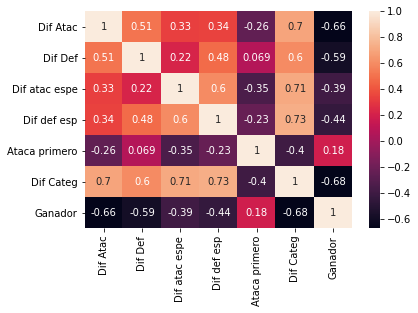

In [5]:
#Comprobamos que hay correlaciones importantes entre el ganador y la diferencia de categoría, ataque y defensa.
sns.heatmap(data= df_combates_pokemons_train.corr(), annot=True)

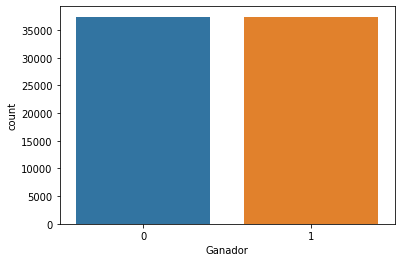

In [6]:
#Como esperábamos tenemos equilibrados los ganadores
sns.countplot(data=df_combates_pokemons_train, x=df_combates_pokemons_train['Ganador'])

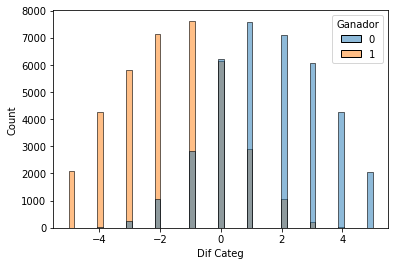

In [11]:
#Comprobamos que la diferenciad e categoría es un factor importante a medida que la diferencia es mayor. 
#PArece un buen punto de partida de separación de nodos en árboles de decisión
sns.histplot(data= df_combates_pokemons_train, x=df_combates_pokemons_train['Dif Categ'], hue=df_combates_pokemons_train['Ganador'],stat='count')

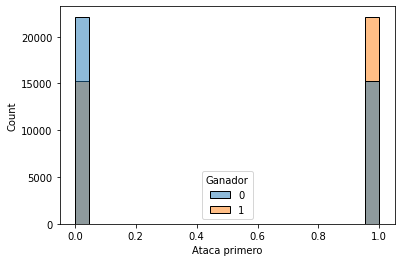

In [12]:
#Atacar primero parece que da cierta ventaja
sns.histplot(data= df_combates_pokemons_train, x=df_combates_pokemons_train['Ataca primero'], hue=df_combates_pokemons_train['Ganador'],stat='count')

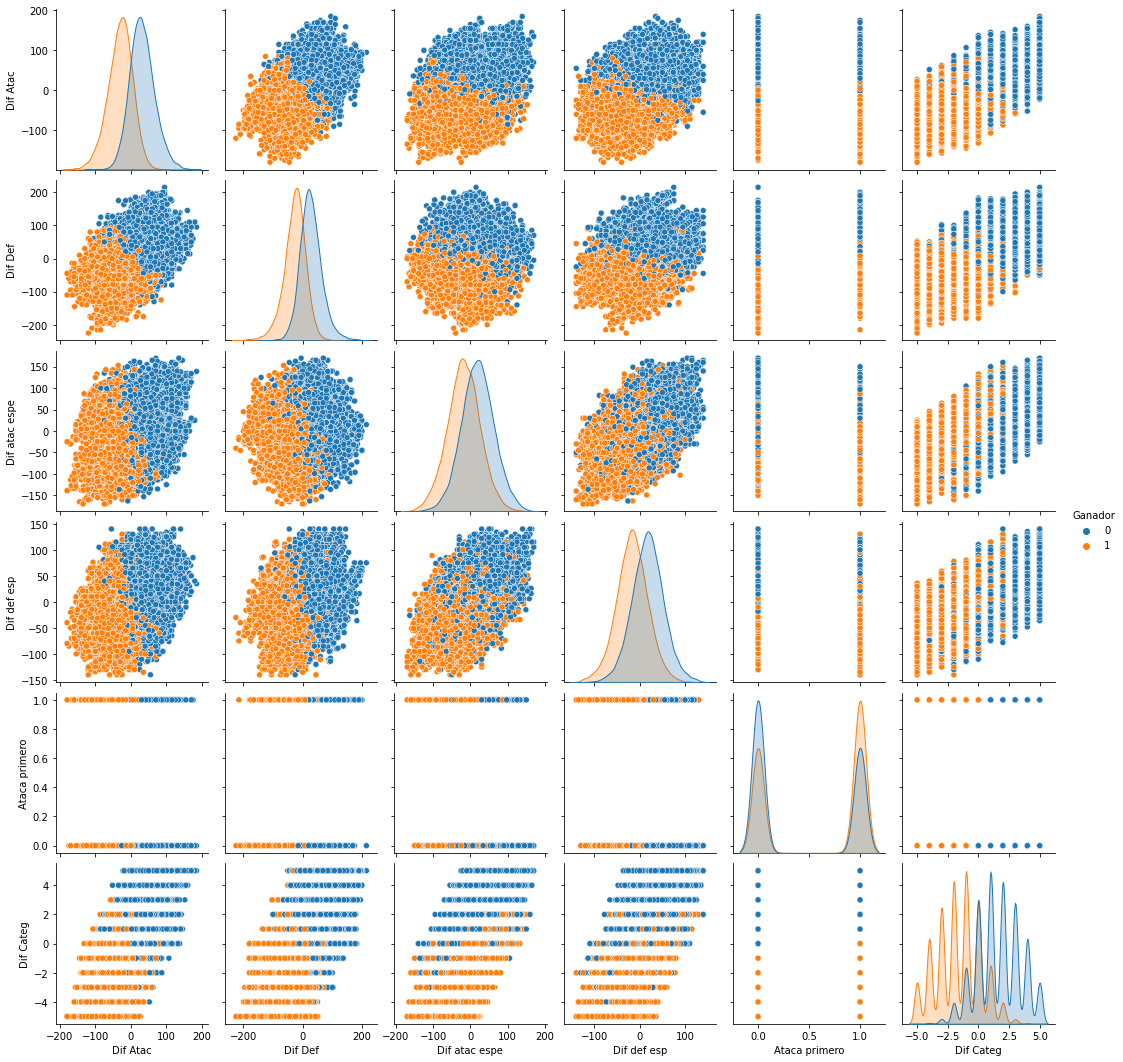

In [7]:
#Aunque parece que hay algunos outliers, es bastante claro que hay modelos que deberían funcionar bien como Knn o LogisticRegression, incluso XGBoost.
sns.pairplot(df_combates_pokemons_train, hue='Ganador')

# 3.PRUEBAS CON MODELOS
### Importamos librerías necesarias y recursos


* Librería para usar BayesSearchCV, un grid de tuneado bayesiano

In [14]:
pip install scikit-optimize

     |████████████████████████████████| 101 kB 6.2 MB/s 


In [15]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score, brier_score_loss
from sklearn.pipeline import Pipeline, make_pipeline
import tensorflow.keras as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
import joblib

## 3.1 PRUEBAS CON MODELOS SIMPLES



## Creación de sets, funciones y tablas de comparación genéricas
* Creamos el set de entrenamiento y el de test
* Creamos una función para tunear los modelos que se desee con BayesSearchCV.
* Creamos el DF de modelos que englobará todos los modelos después de la búsqueda de los mejores parámetros. 
* El DF de modelos contiene el mejor modelo tras la optimización de hiperparámetros y la columna 'scaler' que nos indica si es necesario escalar los datos antes de hacer el fit y predict.
* Creamos también una tabla que usaremos más tarde para comparar modelos y construida con estos valores:
  * *Precisión del modelo, Precisión entrenamiento, Cross_val_score de test, ROC-AUC score, Std de CV, Brier Loss, tiempo de ejecución fit y tiempo de ejecución predict*
  
  Esta tabla se usará más tarde en la función EvalMod que es la que devuelve las métricas tras pasar los diferentes modelos por ella.

  **Nota**

*Aunque lo normal es primero hacer CV para validar el modelo y luego buscar los parámetros la decisión de hacerlo al contrario es la siguiente*:

*Acorde con los datos parece que algunas características se distribuyen siguiendo una función Gaussiana, así que es de esperar que todos los modelos de clasificación se comporten bien, así que el CV lo usamos después de buscar los parámetros como otra medida de valoración a la hora de elegir el modelo óptimo.*


In [ ]:
X = df_combates_pokemons_train.drop('Ganador',axis=1)
y = df_combates_pokemons_train['Ganador']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=14)

#Escalamos los valores para los modelos que lo necesitan
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
#Creamos los Dataframes para pasar luego por la función de comparación

modelos = pd.DataFrame(columns=['modelo','scaler'])
comparativa_modelos = pd.DataFrame(columns=['Modelo', 'Prec_test', 'Prec_train',
                                            'Prec_cv','ROC-AUC','STD_cv','Brier_loss',
                                            'T_ejec_fit', 'T_ejec_pred'])

In [ ]:
#Creamos la función para buscar los mejores hiperparámetros en los modelos seleccionados que lo requieran

def TuningModel(modelo, parametros, X_train, y_train, verbose=1, scoring='accuracy'):
    
    start = time.time()
    mod_bayes_grid = BayesSearchCV(modelo, parametros, verbose=verbose, scoring=scoring)
    mod_bayes_grid.fit(X_train, y_train)
    stop = time.time()
    print("Tiempo de entrenamiento del Bayesian Search: ", (stop - start), " segundos")

    return mod_bayes_grid.best_estimator_

### KNN
  * Usamos los valores a los que hemos aplicad un StandardScaler

In [ ]:
mod_Knn = KNeighborsClassifier()
vecinos = np.arange(5,71,5)
parametros = {
    'n_neighbors':vecinos,
    'weights': ['uniform','distance'], 
    'leaf_size':np.linspace(1,10,10).astype(int)
    }

In [ ]:
mod_Knn = TuningModel(mod_Knn,parametros, X_train_sc, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.8s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s finished


Tiempo de entrenamiento del Bayesian Search:  468.8186311721802  segundos


In [ ]:
mod_Knn

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=65, p=2,
                     weights='uniform')

In [ ]:
modelos = modelos.append({'modelo':mod_Knn, 'scaler':True}  , ignore_index=True)

In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(mod_Knn, 'Modelo_KNN.sav')

['Modelo_KNN.sav']

### SGD
  * Usamos los datos a los que aplicamos Standard Scaler


In [ ]:
mod_sgd = SGDClassifier(loss='modified_huber')
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive'] 
eta0 = [1, 10, 100] 
parametros = dict(penalty=penalty, 
alpha=alpha, 
learning_rate=learning_rate,
eta0=eta0) 


In [ ]:
mod_sgd = TuningModel(mod_sgd ,parametros, X_train_sc, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Tiempo de entrenamiento del Bayesian Search:  163.76155972480774  segundos


In [20]:
mod_sgd

SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
modelos = modelos.append({'modelo':mod_sgd, 'scaler':True}  , ignore_index=True)

In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(mod_sgd, 'Modelo_SGD.sav')

['Modelo_SGD.sav']

### LOGISTIC REGRESSION

In [ ]:
mod_lr = LogisticRegression()
parametros = {'C': [ 1, 50, 100, 150], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter':[100, 150,200]}

In [ ]:
mod_lr = TuningModel(mod_lr,parametros, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: Convergenc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: Convergenc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: Convergenc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: Convergenc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: Convergenc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: Convergenc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: Convergenc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: Convergenc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: Convergenc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: Convergenc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: Convergenc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Tiempo de entrenamiento del Bayesian Search:  267.6298146247864  segundos


In [22]:
mod_lr 

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=150,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
modelos = modelos.append({'modelo':mod_lr, 'scaler':False}  , ignore_index=True)

In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(mod_lr, 'Modelo_LR.sav')

['Modelo_LR.sav']

### LIGHT GRADIENT BOOST CLASSIFIER

In [ ]:
modL = LGBMClassifier(objective='binary', n_estimators=150 )
parametros = {'num_leaves': [31,50,70],
              'learning_rate':[0.1,0.05,0.001],
              'max_depth':[-1,7,10,30]
}

In [ ]:
modL = TuningModel(modL,parametros, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.4s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.3s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.2s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished


Tiempo de entrenamiento del Bayesian Search:  283.37266969680786  segundos


In [ ]:
modL

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=150, n_jobs=-1, num_leaves=50, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
modelos = modelos.append({'modelo':modL, 'scaler':False}  , ignore_index=True)

In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(modL, 'Modelo_LGBM')

['Modelo_LGBM']

## 3.2 PRUEBAS CON MODELOS DE ENSAMBLE Y REDES NEURONALES

Primero probamos modelos ensemble como XGBoost o ADAboost y posteriormente modelos de Stack o voting classifier de Sklearn. Luego añadimos una red neuronal y Vstack, un desarrollo de Stacking models



 ### XGBOOST

In [ ]:
mod_xgb = XGBClassifier(n_estimators=500)
parametros = {'colsample_bylevel': [0.1,0.3,0.8,1],
              'colsample_bynode': [0.3,0.5,1],
              'gamma' : [0.05, 0.1, 0.2, 0.5, 1],
              'learning_rate': [0.005, 0.02,0.05],
              'max_depth': [1,2,4,6],
              'min_child_weight': [1,5,6,9],
              'subsample': [0.5,0.8,1]        
              }

In [ ]:
mod_xgb = TuningModel(mod_xgb,parametros, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   43.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   39.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   39.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   39.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.8s finished


Tiempo de entrenamiento del Bayesian Search:  2059.922529935837  segundos


In [ ]:
mod_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.1,
              colsample_bynode=1.0, colsample_bytree=1, gamma=0.05,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [ ]:
modelos = modelos.append({'modelo':mod_xgb, 'scaler':False}  , ignore_index=True)

In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(mod_xgb, 'Modelo_xgb')

['Modelo_xgb']

### ADABOOST

In [ ]:
mod_adaboost = AdaBoostClassifier(n_estimators=150, random_state=14)
parametros = {     
    'learning_rate': [0.05,0.1,0.5,0.8]
}

In [ ]:
mod_adaboost = TuningModel(mod_adaboost,parametros, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.6s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.6s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.4s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.5s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.5s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.3s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.5s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.3s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.3s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.2s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.3s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.4s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.2s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.2s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.6s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.5s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.4s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.7s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.2s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.4s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.4s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.1s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.9s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.9s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.3s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.9s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.0s finished
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.0s finished


Tiempo de entrenamiento del Bayesian Search:  1196.5715169906616  segundos


In [ ]:
mod_adaboost

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=150, random_state=14)

In [ ]:
modelos = modelos.append({'modelo':mod_adaboost, 'scaler':False}  , ignore_index=True)

In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(mod_adaboost, 'Modelo_adaboost.sav')

['Modelo_adaboost.sav']

### RANDOM FOREST

In [ ]:
mod_rndForest = RandomForestClassifier(verbose=3, n_jobs=-1, random_state=14)
max_depth = [int(x) for x in np.linspace(5, 35, num = 10)]
max_depth.append(None)
parametros = {
    'n_estimators': [100, 200],
    'max_depth': max_depth
}

In [ ]:
mod_rndForest = TuningModel(mod_rndForest,parametros, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 out of 124 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 out of 124 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Pa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 142 out of 145 | elapsed:    5.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 145 out of 145 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 142 out of 145 | elapsed:    5.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    5.4s finish

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 126 out of 129 | elapsed:    4.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    5.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 129 out of 129 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 126 out of 129 | elapsed:    4.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    4.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 183 out of 186 | elapsed:    7.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 186 out of 186 | elapsed:    7.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 186 out of 186 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 186 out of 186 | elapsed:    7.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 186 out of 186 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using back

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    4.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 123 out of 123 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    4.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 123 out of 123 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Pa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    5.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 154 out of 154 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:    5.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 154 out of 154 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 143 out of 143 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 143 out of 143 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:    7.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 199 out of 199 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:    7.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 199 out of 199 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 118 out of 121 | elapsed:    4.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    4.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 121 out of 121 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 118 out of 121 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    4.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elap

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    5.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 155 out of 155 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:    5.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 199 out of 199 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Pa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 199 out of 199 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Pa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Pa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Pa

building tree 1 of 143
building tree 2 of 143
building tree 3 of 143
building tree 4 of 143
building tree 5 of 143
building tree 6 of 143
building tree 7 of 143
building tree 8 of 143
building tree 9 of 143
building tree 10 of 143
building tree 11 of 143
building tree 12 of 143
building tree 13 of 143
building tree 14 of 143
building tree 15 of 143
building tree 16 of 143
building tree 17 of 143
building tree 18 of 143
building tree 19 of 143
building tree 20 of 143
building tree 21 of 143building tree 22 of 143

building tree 23 of 143
building tree 24 of 143
building tree 25 of 143
building tree 26 of 143
building tree 27 of 143
building tree 28 of 143
building tree 29 of 143
building tree 30 of 143
building tree 31 of 143
building tree 32 of 143


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s


building tree 33 of 143
building tree 34 of 143
building tree 35 of 143
building tree 36 of 143
building tree 37 of 143
building tree 38 of 143
building tree 39 of 143
building tree 40 of 143
building tree 41 of 143
building tree 42 of 143
building tree 43 of 143
building tree 44 of 143
building tree 45 of 143
building tree 46 of 143
building tree 47 of 143
building tree 48 of 143
building tree 49 of 143
building tree 50 of 143
building tree 51 of 143
building tree 52 of 143
building tree 53 of 143
building tree 54 of 143
building tree 55 of 143
building tree 56 of 143
building tree 57 of 143
building tree 58 of 143
building tree 59 of 143
building tree 60 of 143
building tree 61 of 143
building tree 62 of 143
building tree 63 of 143
building tree 64 of 143
building tree 65 of 143
building tree 66 of 143
building tree 67 of 143
building tree 68 of 143
building tree 69 of 143
building tree 70 of 143
building tree 71 of 143
building tree 72 of 143
building tree 73 of 143
building tree 74

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    3.5s


building tree 130 of 143
building tree 131 of 143
building tree 132 of 143
building tree 133 of 143
building tree 134 of 143
building tree 135 of 143
building tree 136 of 143
building tree 137 of 143
building tree 138 of 143
building tree 139 of 143
building tree 140 of 143
building tree 141 of 143
building tree 142 of 143
building tree 143 of 143
Tiempo de entrenamiento del Bayesian Search:  1026.9288895130157  segundos


[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    4.0s finished


In [17]:
mod_rndForest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=143,
                       n_jobs=-1, oob_score=False, random_state=14, verbose=3,
                       warm_start=False)

In [ ]:
modelos = modelos.append({'modelo':mod_rndForest, 'scaler':False}  , ignore_index=True)

In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(mod_rndForest, 'Modelo Random forest.sav')

['Modelo Random forest.sav']

### EXTRA TREES CL

In [ ]:
mod_extrTrees = ExtraTreesClassifier (verbose=3, n_jobs=-1, random_state=14)
max_depth = [int(x) for x in np.linspace(5, 35, num = 10)]
max_depth.append(None)
params = {
    'n_estimators': [100,200],
    'max_depth': max_depth,
    'warm_start': ['True', 'False'],
    'ccp_alpha': [0,0.01, 0.05]
}

In [ ]:
mod_extrTrees= TuningModel(mod_extrTrees,parametros, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:    5.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 171 out of 171 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:    5.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 110 out of 110 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 110 out of 110 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]:

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 140 out of 140 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 140 out of 140 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 188 out of 188 | elapsed:    4.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 188 out of 188 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 188 out of 188 | elapsed:    4.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 188 out of 188 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 110 out of 110 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 110 out of 110 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent work

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 165 out of 165 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 165 out of 165 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 103 out of 103 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 103 out of 103 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 176 out of 176 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 176 out of 176 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Pa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 101 out of 101 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 101 out of 101 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Pa

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend wit

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200building tree 6 of 200

building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s


building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200building tree 64 of 200

building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.6s


building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.1s finished


In [ ]:
mod_extrTrees

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=18, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                     oob_score=False, random_state=14, verbose=3,
                     warm_start=False)

In [ ]:
modelos = modelos.append({'modelo':mod_extrTrees, 'scaler':False}  , ignore_index=True)

In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(mod_extrTrees, 'Modelo Extra Trees.sav')

['Modelo Extra Trees.sav']

## PROBANDO ENSEMBLES MANUALES

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, StackingClassifier, VotingClassifier

In [ ]:
modelos_ens = [('et', ExtraTreesClassifier(random_state=0, n_jobs=-1, n_estimators=100, max_depth=2)), 
            ('lr', LogisticRegression()),
            ('ab',AdaBoostClassifier(n_estimators=100, learning_rate=0.05)), 
            ('lgbm',LGBMClassifier(random_state=0, n_jobs=-1, learning_rate=0.05, n_estimators=100, max_depth=3))
]

### Voting Classifier

In [ ]:
mod_vc = VotingClassifier(estimators=modelos_ens,voting='soft')
modelos = modelos.append({'modelo':mod_vc, 'scaler':True}  , ignore_index=True)

In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(mod_vc, 'Modelo_voting_sklearn')

['Modelo_voting_sklearn']

### StackingEnsemble

In [ ]:
final_estimator = XGBClassifier(random_state=14, n_jobs=-1, learning_rate=0.05, n_estimators=100, max_depth=3)
Mod_stac_clss = StackingClassifier(estimators=modelos_ens, final_estimator=final_estimator)

modelos = modelos.append({'modelo':Mod_stac_clss, 'scaler':True}  , ignore_index=True)


In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(Mod_stac_clss, 'Modelo_stacking_sklearn')

['Modelo_stacking_sklearn']

### Bagging Classifer

In [ ]:
mod_bagg = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5)

modelos = modelos.append({'modelo':mod_bagg, 'scaler':False}  , ignore_index=True)

In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(mod_bagg, 'Modelo_bagging_sklearn')

['Modelo_bagging_sklearn']

### GradientBoostingClassifier

In [ ]:
mod_gbc = GradientBoostingClassifier(learning_rate = 0.05, subsample=0.9, ccp_alpha= 0.015)
modelos = modelos.append({'modelo':mod_gbc, 'scaler':False}  , ignore_index=True)

In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(mod_gbc, 'Modelo_GradientBoostC_sklearn')

['Modelo_GradientBoostC_sklearn']

## 3.3 EVALUAMOS LOS MODELOS

* Vstack se evalúa después porque transforma los valores de entrenamiento y test

* TensorFlow también se evalúa por separado


In [ ]:
#Comprobamos que están todos los modelos
modelos

,modelo,scaler
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",True
1,"SGDClassifier(alpha=0.01, average=False, class...",True
2,"LogisticRegression(C=100, class_weight=None, d...",False
3,"LGBMClassifier(boosting_type='gbdt', class_wei...",False
4,"XGBClassifier(base_score=0.5, booster='gbtree'...",False
5,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",False
6,"RandomForestClassifier(bootstrap=True, ccp_alp...",False
7,"ExtraTreesClassifier(bootstrap=False, ccp_alph...",False
8,"VotingClassifier(estimators=[('et',\n ...",True
9,"StackingClassifier(cv=None,\n ...",True


In [ ]:
#Este DF estará disponible como recurso pero este comando permite guardarlo en localjoblib.dump(modelos, 'Modelos.sav')

['Modelos.sav']

### Creamos la Clase EvalModelos
* Esta clase nos hace la evaluación de los modelos a través de la función evaluar. Devuelve un objeto Dataframe con estas métricas:
    * Accuracy de test / entrenamiento / CrossVal
    * Standard Deviation del CV
    * Brier Loss
    * ROC-AUC 
    * Tiempos de ejecución de entrenamiento y predicción

* Además tiene tres funciones más: 
    * get_models: devuelve los modelos que se pasan a evaluación
    * set_param :Permite incluir un diccionario de parámetros en un modelo seleccionado
    * get_param : Recupera los parámetros del modelo seleccionado
  
* Esta clase puede usarse para uno o varios modelos

* Al entrar el modelo se evalúa primero si necesita escalar los datos. Si es así procede a ello en primer lugar, en caso contrario directamente evalúa los modelos.


In [ ]:
class EvalModelos:
  ## Primero definimos init al que le pasamos self, modelos, X e y y crea el split de datos
  def __init__(self, modelos, X_train, y_train, X_test, y_test ):
    self.X_train = X_train
    self.X_test =  X_test
    self.y_train = y_train
    self.y_test =  y_test

    self.comparativa_modelos = pd.DataFrame(columns=['Modelo', 'Prec_test', 'Prec_train','Prec_cv',
                                                'ROC-AUC','STD_cv','Brier_loss','T_ejec_fit', 
                                                'T_ejec_pred'])
    self.modelos = modelos
    
  ## Despues la función evaluar que es EvalMod con el bucle para varios modelos si se pasan varios. 
  ## Se podría hacer un Tensorflow = False  y Mlens = False pero complica mucho la clase
  def evaluar (self):
    
    
    def EvalMod (modelo, X_train, y_train, X_test, y_test):
      print("Fitting modelo ", str(modelo).split('(')[0])
      kfold = KFold(5,shuffle=True)
      start = time.time()
      modelo.fit(X_train, y_train)
      t_ejec = time.time() - start
      print("prediciendo modelo ", str(modelo).split('(')[0])
      start_p = time.time()
      pred_mod = modelo.predict(X_test)
      prec_mod = accuracy_score(y_test, pred_mod)
      t_ejec_p = time.time() - start
      print("Empezando CrossValidation", str(modelo).split('(')[0])
      prec_mod_cv = cross_val_score(modelo, X_train, y_train, cv=kfold).mean()
      std_prec_cv = statistics.stdev(cross_val_score(modelo, X_train, y_train))
      roc_auc = roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1])
      prec_mod_train = modelo.score(X_train, y_train)
      brier_loss = brier_score_loss(y_test,modelo.predict_proba(X_test)[:,1] )
      return ({'Modelo':str(modelo).split('(')[0], 
                'Prec_test':prec_mod, 
                'Prec_train':prec_mod_train,
                'Prec_cv':prec_mod_cv,
                'ROC-AUC':roc_auc,
                'STD_cv':std_prec_cv,
                'Brier_loss':brier_loss,
                'T_ejec_fit':t_ejec,
                'T_ejec_pred':t_ejec_p
              }
              )
      
    for mod in self.modelos.index:

      if self.modelos['scaler'][mod]==True:
        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(self.X_train)
        X_test_sc = scaler.transform(self.X_test)
        self.eval_modelo = EvalMod(self.modelos['modelo'][mod], X_train_sc, self.y_train, X_test_sc, self.y_test)
        self.comparativa_modelos = self.comparativa_modelos.append(self.eval_modelo, ignore_index=True)
      else:
        self.eval_modelo = EvalMod(self.modelos['modelo'][mod], self.X_train, self.y_train, self.X_test, self.y_test)
        self.comparativa_modelos = self.comparativa_modelos.append(self.eval_modelo, ignore_index=True)
      
    return self.comparativa_modelos

  ## Después la función get_model que devuelve los modelos que se están utilizando

  def get_models (self):
    return self.modelos

  ## Después la función set_params que permite poner parámetros a modelos. 
  #Se le pasa el índice del modelo y el parámetro en forma de dict

  def set_param (self, index, params):
     ## Params debe ser un diccionario con los parámetros adecuados,
     ## e index el índice del modelo dentro de la lista de modelos 
    self.mod = self.modelos[index]
    for parameter, value in params.items():
        setattr( self.mod, parameter, value)
    return self.mod

  #Después la funcion get_params que permite saber los parámetros de los modelos. 
  #Por defecto es True y devuelve todos, pero si es false se le pasa el índice del modelo que queremos dentro de la lista de modelos

  def get_param (self, index):
    # Hay que pasar el índice del modelo dentro de la lista de modelos
    return self.modelos[index].get_params()

### Evaluamos los modelos y lo añadimos a la comparativa

In [ ]:
start= time.time()
resultado = EvalModelos(modelos, X_train, y_train, X_test, y_test).evaluar()
comparativa_modelos = comparativa_modelos.append(resultado,ignore_index=True)
stop = time.time()
comparativa_modelos


Fitting modelo  KNeighborsClassifier
prediciendo modelo  KNeighborsClassifier
Empezando CrossValidation KNeighborsClassifier
Fitting modelo  SGDClassifier
prediciendo modelo  SGDClassifier
Empezando CrossValidation SGDClassifier
Fitting modelo  LogisticRegression
prediciendo modelo  LogisticRegression
Empezando CrossValidation LogisticRegression


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Fitting modelo  LGBMClassifier
prediciendo modelo  LGBMClassifier
Empezando CrossValidation LGBMClassifier
Fitting modelo  XGBClassifier
prediciendo modelo  XGBClassifier
Empezando CrossValidation XGBClassifier
Fitting modelo  AdaBoostClassifier
prediciendo modelo  AdaBoostClassifier
Empezando CrossValidation AdaBoostClassifier
Fitting modelo  RandomForestClassifier
building tree 1 of 143
building tree 2 of 143
building tree 3 of 143building tree 4 of 143

building tree 5 of 143
building tree 6 of 143


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 7 of 143
building tree 8 of 143
building tree 9 of 143
building tree 10 of 143
building tree 11 of 143
building tree 12 of 143
building tree 13 of 143
building tree 14 of 143
building tree 15 of 143
building tree 16 of 143
building tree 17 of 143
building tree 18 of 143
building tree 19 of 143
building tree 20 of 143
building tree 21 of 143
building tree 22 of 143
building tree 23 of 143
building tree 24 of 143
building tree 25 of 143
building tree 26 of 143
building tree 27 of 143
building tree 28 of 143
building tree 29 of 143
building tree 30 of 143


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s


building tree 31 of 143
building tree 32 of 143
building tree 33 of 143
building tree 34 of 143
building tree 35 of 143
building tree 36 of 143
building tree 37 of 143
building tree 38 of 143
building tree 39 of 143
building tree 40 of 143building tree 41 of 143

building tree 42 of 143
building tree 43 of 143
building tree 44 of 143
building tree 45 of 143
building tree 46 of 143
building tree 47 of 143
building tree 48 of 143
building tree 49 of 143
building tree 50 of 143
building tree 51 of 143
building tree 52 of 143
building tree 53 of 143
building tree 54 of 143
building tree 55 of 143
building tree 56 of 143
building tree 57 of 143
building tree 58 of 143
building tree 59 of 143
building tree 60 of 143
building tree 61 of 143
building tree 62 of 143
building tree 63 of 143building tree 64 of 143

building tree 65 of 143
building tree 66 of 143
building tree 67 of 143
building tree 68 of 143
building tree 69 of 143building tree 70 of 143

building tree 71 of 143
building tree 72

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    3.4s


building tree 132 of 143
building tree 133 of 143
building tree 134 of 143
building tree 135 of 143
building tree 136 of 143
building tree 137 of 143
building tree 138 of 143
building tree 139 of 143
building tree 140 of 143
building tree 141 of 143
building tree 142 of 143
building tree 143 of 143
prediciendo modelo  RandomForestClassifier


[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    3.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s


Empezando CrossValidation RandomForestClassifier


[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 143 out of 143 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    4.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 143 out of 143 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks  

Fitting modelo  ExtraTreesClassifier
building tree 1 of 200
building tree 2 of 200
building tree 3 of 200building tree 4 of 200

building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s


building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.6s


building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s


prediciendo modelo  ExtraTreesClassifier


[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Empezando CrossValidation ExtraTreesClassifier


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks 

Fitting modelo  VotingClassifier
prediciendo modelo  VotingClassifier
Empezando CrossValidation VotingClassifier
Fitting modelo  StackingClassifier
prediciendo modelo  StackingClassifier
Empezando CrossValidation StackingClassifier
Fitting modelo  BaggingClassifier
prediciendo modelo  BaggingClassifier
Empezando CrossValidation BaggingClassifier
Fitting modelo  GradientBoostingClassifier
prediciendo modelo  GradientBoostingClassifier
Empezando CrossValidation GradientBoostingClassifier


,Modelo,Prec_test,Prec_train,Prec_cv,ROC-AUC,STD_cv,Brier_loss,T_ejec_fit,T_ejec_pred
0,KNeighborsClassifier,0.883579,0.888028,0.885045,0.957137,0.003960,0.082384,0.099634,4.217496
1,SGDClassifier,0.885096,0.886020,0.886001,0.956745,0.004052,0.083723,0.052886,0.061650
2,LogisticRegression,0.883891,0.886269,0.886384,0.957768,0.003781,0.082209,0.413439,0.421207
3,LGBMClassifier,0.884293,0.895009,0.884682,0.958218,0.003918,0.081690,0.997715,1.148519
4,XGBClassifier,0.885096,0.889902,0.885561,0.958369,0.004466,0.081615,9.784702,10.263939
5,AdaBoostClassifier,0.882731,0.885561,0.884968,0.957475,0.003897,0.203215,4.873656,5.398355
6,RandomForestClassifier,0.883623,0.893402,0.885179,0.957193,0.003563,0.082579,3.980842,4.289679
7,ExtraTreesClassifier,0.879473,0.918283,0.881870,0.955401,0.003112,0.084507,4.306337,5.017942
8,VotingClassifier,0.884070,0.886537,0.885542,0.957455,0.003336,0.102220,4.805827,5.499260
9,StackingClassifier,0.884828,0.886498,0.885542,0.957974,0.003744,0.082062,28.445195,29.188657


In [ ]:
print("Tiempo empleado en evaluar todos los modelos: ", (stop-start)/60, " Minutos")

Tiempo empleado en evaluar todos los modelos:  11.396841776371001  Minutos


Ahora vamos a evaluar dos modelos por separado que requieren ciertos procesos que no se pueden integrar en los procesos anteriores. Los modelos son:

* **Tensorflow**
* **Vstack**

### 3.3.1 TENSORFLOW

### Preparación del modelo
* Tras varias pruebas los mejores valores obtenidos son:

    *   Tres layers sin dropout
    *   MinMaxscaler como scaler en vez de StandardScaler
    *   Partimos el bloque de test en dos, uno de validación y otro de test para tener un earl stop de loss validation en el fit.
    *   CV no se usa generalmente en redes neuronales ya que la eficiencia de la red se basa principalmente en el conjunto de datos, el número de epochs y la tasa de aprendizaje. En cualquier caso vamos a hacer un cv con KerasClassifier



In [ ]:
model_tf = Sequential()
scaler_tf = MinMaxScaler()


y_train_tf = y_train.values
y_test_tf = y_test.values
X_train_tf = scaler_tf.fit_transform(X_train.values)
X_test_tf = scaler_tf.transform(X_test.values)

X_val_tf, X_test_2_tf, y_val_tf, y_test_2_tf = train_test_split(X_test_tf, y_test_tf, test_size=0.5, random_state=14)

earlstop = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=20)


In [ ]:
model_tf.add(Dense(6, activation='relu'))
model_tf.add(Dense(12, activation='relu'))
model_tf.add(Dense(1, activation='sigmoid'))


### Compilación, fitting y  evaluación del modelo


In [ ]:
model_tf.compile(loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy',tf.metrics.AUC()])

Realizamos CrossValidation con KerasClassifier

In [ ]:
def buildmodel():
    model= Sequential([
        Dense(6, activation='relu'),
        Dense(12, activation='relu'),
        Dense(1, activation='sigmoid')])
    model.compile(loss='BinaryCrossentropy', optimizer='adam', metrics='accuracy')
    return model

estimator= KerasClassifier(build_fn=buildmodel, epochs=200, batch_size=250, verbose=1)
start=time.time()
kfold= kfold = KFold(5,shuffle=True, random_state=14)
results= cross_val_score(estimator, X_train_tf, y_train_tf, cv=kfold, n_jobs=-1, verbose=3)
print('Tiempo CV: ',(time.time())-start, ' minutos')
results.mean() 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Tiempo CV:  188.92397904396057  minutos


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


0.8859055042266846

In [ ]:
start = time.time()
history = model_tf.fit(X_train_tf, y_train_tf, 
                       verbose=1, batch_size=250,
                       callbacks=earlstop, epochs=600, 
                       validation_data=(X_val_tf, y_val_tf)
                       )
t_ejec = time.time() - start

start_p = time.time()
metrics = model_tf.evaluate(X_test_2_tf, y_test_2_tf)
metrics_tr = model_tf.evaluate(X_train_tf, y_train_tf)
metrics_val = model_tf.evaluate(X_val_tf, y_val_tf)
metrics_tr, metrics_val, metrics
t_ejec_p = time.time() - start_p



Epoch 1/600
210/210 [==============================] - 2s 4ms/step - loss: 0.6577 - accuracy: 0.6983 - auc: 0.7624 - val_loss: 0.5839 - val_accuracy: 0.7489 - val_auc: 0.8612
Epoch 2/600
210/210 [==============================] - 1s 2ms/step - loss: 0.4892 - accuracy: 0.7970 - auc: 0.8965 - val_loss: 0.4021 - val_accuracy: 0.8433 - val_auc: 0.9299
Epoch 3/600
210/210 [==============================] - 1s 2ms/step - loss: 0.3496 - accuracy: 0.8575 - auc: 0.9376 - val_loss: 0.3162 - val_accuracy: 0.8650 - val_auc: 0.9438
Epoch 4/600
210/210 [==============================] - 1s 3ms/step - loss: 0.3049 - accuracy: 0.8674 - auc: 0.9455 - val_loss: 0.2954 - val_accuracy: 0.8697 - val_auc: 0.9481
Epoch 5/600
210/210 [==============================] - 1s 2ms/step - loss: 0.2906 - accuracy: 0.8720 - auc: 0.9491 - val_loss: 0.2863 - val_accuracy: 0.8733 - val_auc: 0.9505
Epoch 6/600
210/210 [==============================] - 0s 2ms/step - loss: 0.2828 - accuracy: 0.8753 - auc: 0.9514 - val_loss

In [ ]:
std_prec_cv = statistics.stdev(results)

In [ ]:
import tensorflow_probability as tfp
brier_loss = tfp.stats.brier_score(y_test_tf, model_tf.predict(X_test_tf), name=None)
brier_loss = np.array(brier_loss[:]).mean()

In [ ]:
valores = ({'Modelo':'TensorFlow', 
            'Prec_test':metrics[1], 
            'Prec_train':metrics_tr[1],
            'Prec_cv':results.mean(),
            'ROC-AUC':metrics_tr[2],
            'STD_cv': std_prec_cv,
            'Brier_loss': brier_loss,
            'T_ejec_fit':t_ejec,
            'T_ejec_pred':t_ejec_p})

In [ ]:
valores

{'Brier_loss': -0.0051762606,
 'Modelo': 'TensorFlow',
 'Prec_cv': 0.8859055042266846,
 'Prec_test': 0.8855867981910706,
 'Prec_train': 0.8859629034996033,
 'ROC-AUC': 0.9588832855224609,
 'STD_cv': 0.0011422504566962154,
 'T_ejec_fit': 37.597949266433716,
 'T_ejec_pred': 3.325302839279175}

In [ ]:
#Añadimos Tensor Flow
comparativa_modelos = comparativa_modelos.append(valores,ignore_index=True)
comparativa_modelos

,Modelo,Prec_test,Prec_train,Prec_cv,ROC-AUC,STD_cv,Brier_loss,T_ejec_fit,T_ejec_pred
0,KNeighborsClassifier,0.883579,0.888028,0.885045,0.957137,0.003960,0.082384,0.099634,4.217496
1,SGDClassifier,0.885096,0.886020,0.886001,0.956745,0.004052,0.083723,0.052886,0.061650
2,LogisticRegression,0.883891,0.886269,0.886384,0.957768,0.003781,0.082209,0.413439,0.421207
3,LGBMClassifier,0.884293,0.895009,0.884682,0.958218,0.003918,0.081690,0.997715,1.148519
4,XGBClassifier,0.885096,0.889902,0.885561,0.958369,0.004466,0.081615,9.784702,10.263939
5,AdaBoostClassifier,0.882731,0.885561,0.884968,0.957475,0.003897,0.203215,4.873656,5.398355
6,RandomForestClassifier,0.883623,0.893402,0.885179,0.957193,0.003563,0.082579,3.980842,4.289679
7,ExtraTreesClassifier,0.879473,0.918283,0.881870,0.955401,0.003112,0.084507,4.306337,5.017942
8,VotingClassifier,0.884070,0.886537,0.885542,0.957455,0.003336,0.102220,4.805827,5.499260
9,StackingClassifier,0.884828,0.886498,0.885542,0.957974,0.003744,0.082062,28.445195,29.188657


In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
model_tf.save('Modelo_Tf.h5')

### 3.3.2 PROBANDO ENSEMBLE CON VSTACK

In [ ]:
pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19880 sha256=32c006a1e922b4e42d1df3fbdebc81847aadb5651a44fe0ca31443710f6a46bc
  Stored in directory: /root/.cache/pip/wheels/28/fe/0c/fe8e43660e3316d7ce204e59a79a72246c0ae9b6c5c79841c8
Successfully built vecstack


In [ ]:
from vecstack import stacking

In [ ]:
modelos = [
    ExtraTreesClassifier(random_state=0, n_jobs=-1, 
                         n_estimators=100, max_depth=2),
    LogisticRegression(),
    
    AdaBoostClassifier(n_estimators=100, learning_rate=0.05),
    
    LGBMClassifier(random_state=0, n_jobs=-1, learning_rate=0.05, 
                   n_estimators=100, max_depth=3),
    
]

In [ ]:
S_train, S_test = stacking(modelos,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and vote
                           needs_proba=False,          # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric=accuracy_score,      # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=False,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=14,             # ensure reproducibility
                           verbose=2)  

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [ExtraTreesClassifier]
    fold  0:  [0.84464163]
    fold  1:  [0.84724241]
    fold  2:  [0.85396267]
    fold  3:  [0.84340575]
    ----
    MEAN:     [0.84731311] + [0.00408123]
    FULL:     [0.84731306]

model  1:     [LogisticRegression]
    fold  0:  [0.88503021]
    fold  1:  [0.88503021]
    fold  2:  [0.89221236]
    fold  3:  [0.88395043]
    ----
    MEAN:     [0.88655581] + [0.00329543]
    FULL:     [0.88655575]

model  2:     [AdaBoostClassifier]
    fold  0:  [0.88250593]
    fold  1:  [0.88135853]
    fold  2:  [0.88792840]
    fold  3:  [0.87744798]
    ----
    MEAN:     [0.88231021] + [0.00374664]
    FULL:     [0.88231019]

model  3:     [LGBMClassifier]
    fold  0:  [0.88510671]
    fold  1:  [0.88281190]
    fold  2:  [0.88838739]
    fold  3:  [0.88157895]
    ----
    MEAN:     [0.88447124] + [0.00259128]
    FULL:     

In [ ]:
model_Vstack = KNeighborsClassifier()
modelo = pd.DataFrame({'modelo':model_Vstack, 'scaler':True}, index=[0])

In [ ]:
eval_modelo = EvalModelos(modelo, S_train, y_train, S_test, y_test).evaluar()


Fitting modelo  KNeighborsClassifier
prediciendo modelo  KNeighborsClassifier
Empezando CrossValidation KNeighborsClassifier


In [ ]:
eval_modelo

,Modelo,Prec_test,Prec_train,Prec_cv,ROC-AUC,STD_cv,Brier_loss,T_ejec_fit,T_ejec_pred
0,KNeighborsClassifier,0.867827,0.868636,0.868063,0.906246,0.003769,0.10988,2.287554,8.588275


Como pone el nombre del estimador final, vamos a poner el nombre de Vstack

In [ ]:
eval_modelo['Modelo']='Vstack'
eval_modelo

,Modelo,Prec_test,Prec_train,Prec_cv,ROC-AUC,STD_cv,Brier_loss,T_ejec_fit,T_ejec_pred
0,Vstack,0.867827,0.868636,0.868063,0.906246,0.003769,0.10988,2.287554,8.588275


In [ ]:
comparativa_modelos = comparativa_modelos.append(eval_modelo,ignore_index=True)

In [ ]:
comparativa_modelos

,Modelo,Prec_test,Prec_train,Prec_cv,ROC-AUC,STD_cv,Brier_loss,T_ejec_fit,T_ejec_pred
0,KNeighborsClassifier,0.883579,0.888028,0.885045,0.957137,0.003960,0.082384,0.099634,4.217496
1,SGDClassifier,0.885096,0.886020,0.886001,0.956745,0.004052,0.083723,0.052886,0.061650
2,LogisticRegression,0.883891,0.886269,0.886384,0.957768,0.003781,0.082209,0.413439,0.421207
3,LGBMClassifier,0.884293,0.895009,0.884682,0.958218,0.003918,0.081690,0.997715,1.148519
4,XGBClassifier,0.885096,0.889902,0.885561,0.958369,0.004466,0.081615,9.784702,10.263939
5,AdaBoostClassifier,0.882731,0.885561,0.884968,0.957475,0.003897,0.203215,4.873656,5.398355
6,RandomForestClassifier,0.883623,0.893402,0.885179,0.957193,0.003563,0.082579,3.980842,4.289679
7,ExtraTreesClassifier,0.879473,0.918283,0.881870,0.955401,0.003112,0.084507,4.306337,5.017942
8,VotingClassifier,0.884070,0.886537,0.885542,0.957455,0.003336,0.102220,4.805827,5.499260
9,StackingClassifier,0.884828,0.886498,0.885542,0.957974,0.003744,0.082062,28.445195,29.188657


In [ ]:
#Este modelo estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(model_Vstack, 'Modelo Vstack.sav')

['Modelo Vstack.sav']

# 4.PROBANDO LOS MEJORES 3 EN DATOS NO VISTOS

  *Criterios de evaluación:
    
    * Media (Prec_test /	Prec_cv ) >	Prec_train >	ROC-AUC >  Brier_loss >  STD_cv 	>	(T_ejec_fit 	T_ejec_pred)
  



In [ ]:
#Este DF estará disponible como recurso pero este comando permite guardarlo en local
joblib.dump(comparativa_modelos,'Comparativa de modelos.sav')

['Comparativa de modelos.sav']

* Asignamos una nueva columna: 'media' que será la principal base de evaluación y estará compuesta por la media entre la precisión de Test y la precisión de CV

In [ ]:
comparativa_modelos

,Modelo,Prec_test,Prec_train,Prec_cv,ROC-AUC,STD_cv,Brier_loss,T_ejec_fit,T_ejec_pred
0,KNeighborsClassifier,0.883579,0.888028,0.885045,0.957137,0.003960,0.082384,0.099634,4.217496
1,SGDClassifier,0.885096,0.886020,0.886001,0.956745,0.004052,0.083723,0.052886,0.061650
2,LogisticRegression,0.883891,0.886269,0.886384,0.957768,0.003781,0.082209,0.413439,0.421207
3,LGBMClassifier,0.884293,0.895009,0.884682,0.958218,0.003918,0.081690,0.997715,1.148519
4,XGBClassifier,0.885096,0.889902,0.885561,0.958369,0.004466,0.081615,9.784702,10.263939
5,AdaBoostClassifier,0.882731,0.885561,0.884968,0.957475,0.003897,0.203215,4.873656,5.398355
6,RandomForestClassifier,0.883623,0.893402,0.885179,0.957193,0.003563,0.082579,3.980842,4.289679
7,ExtraTreesClassifier,0.879473,0.918283,0.881870,0.955401,0.003112,0.084507,4.306337,5.017942
8,VotingClassifier,0.884070,0.886537,0.885542,0.957455,0.003336,0.102220,4.805827,5.499260
9,StackingClassifier,0.884828,0.886498,0.885542,0.957974,0.003744,0.082062,28.445195,29.188657


In [ ]:
comparativa_modelos = comparativa_modelos.assign(media = lambda x: ((x['Prec_test']+x['Prec_cv']) /2 ))

* Escogemos los 6 mejores modelos. Como el ROC_AUC, la STD y el Brier Score están en todos en niveles buenos, nos ceñiremos a realizar la selección de los 3 mejores en función de la precisión de entrenamiento y los tiempos de ejecución

  **Nota:** El brier Score de Tensorflow es negativo. Si fuera el Brier skill score entonces nos diría que no es mejor su predicción que la predicción del modelo base, pero en el API de TF dice que puede dar negativo como un valor normal. Revisando la fórmula no es igual que la de Brier Kill Score así que entiendo que es un valor que justifica el uso de TF como módelo preciso. No he encontrado más info acerca de ello así que cualquier aclaración que permita confirmar o descartar esta aproximación será bienvenida. :-)

In [ ]:
top6 = comparativa_modelos.sort_values(by='media', ascending=False)[:6]

In [ ]:
top6[['Modelo','media','Prec_train','T_ejec_pred','T_ejec_fit']]

,Modelo,media,Prec_train,T_ejec_pred,T_ejec_fit
12,TensorFlow,0.885746,0.885963,3.325303,37.597949
1,SGDClassifier,0.885549,0.886020,0.061650,0.052886
4,XGBClassifier,0.885329,0.889902,10.263939,9.784702
9,StackingClassifier,0.885185,0.886498,29.188657,28.445195
2,LogisticRegression,0.885137,0.886269,0.421207,0.413439
8,VotingClassifier,0.884806,0.886537,5.499260,4.805827


Con estos datos los modelos elegidos son:
  * TensorFlow
  * SGDClassifier
  * Logistic Regression

XGB se cae de la elección por los altos tiempos de ejecución, al igual que StackingClassifier. Ahora procedemos de esta manera:

  * Primero hacemos fit con todo el set de entrenamiento y evaluamos con todo el set de validación que separamos en su momento del 60%

  * Luego probamos un nuevo fitting y evaluación con Crossvalidation con el set de validación que separamos en su momento del 60%

In [ ]:
df_pokemons_entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74700 entries, 0 to 74699
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Dif Atac       74700 non-null  int64
 1   Dif Def        74700 non-null  int64
 2   Dif atac espe  74700 non-null  int64
 3   Dif def esp    74700 non-null  int64
 4   Ataca primero  74700 non-null  int64
 5   Dif Categ      74700 non-null  int64
 6   Ganador        74700 non-null  int64
dtypes: int64(7)
memory usage: 4.0 MB


In [ ]:
df_pokemons_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112049 entries, 0 to 112048
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Dif Atac       112049 non-null  int64
 1   Dif Def        112049 non-null  int64
 2   Dif atac espe  112049 non-null  int64
 3   Dif def esp    112049 non-null  int64
 4   Ataca primero  112049 non-null  int64
 5   Dif Categ      112049 non-null  int64
 6   Ganador        112049 non-null  int64
dtypes: int64(7)
memory usage: 6.0 MB


In [ ]:
top3_eval = pd.DataFrame(columns=['Modelo', 'acc'])
model_top3 = [model_tf,mod_sgd,mod_lr]

Entrenamos los modelos con todo el set de entrenamiento y lo testeamos con el de validación

In [ ]:
## Instanciamos dos procesos de escalado de datos, uno para Tensorflow y otro para Logistic Regression
scaler_tf = MinMaxScaler()
scaler = StandardScaler()

## Separamos los X e y de ambas bases de datos
X = df_pokemons_entrenamiento.drop('Ganador',axis=1)
y = df_pokemons_entrenamiento['Ganador']

X_val = df_pokemons_valid.drop('Ganador',axis=1)
y_val = df_pokemons_valid['Ganador']

## Escalamos los valores con el scaler adecuado para cada modelo

X_tf = scaler_tf.fit_transform(X.values)
y_tf = y.values
X_val_tf = scaler_tf.transform(X_val.values)
y_val_tf = y_val.values
X_sc = scaler.fit_transform(X)
X_val_sc = scaler.transform(X_val)



In [ ]:
model_tf.compile(loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_tf.fit(X_tf, y_tf)
mod_sgd.fit(X_sc, y)
mod_lr.fit(X,y)

2335/2335 [==============================] - 8s 2ms/step - loss: 0.2616 - accuracy: 0.8845


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=150,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
## Calculamos la accuracy de cada modelo

y_p1 = model_tf.predict(X_val_tf)
y_p2 = mod_sgd.predict(X_val_sc)
y_p3 = mod_lr.predict(X_val)
acc1 = model_tf.evaluate(X_val_tf, y_val_tf)[1]
acc2 = accuracy_score(y_val, y_p2)
acc3 = accuracy_score(y_val, y_p3)
top3_eval = top3_eval.append([{ 'Modelo':'TF', 'acc':acc1},
                             {'Modelo':'SGD', 'acc':acc2},
                             {'Modelo':'Logistic', 'acc':acc3}])

3502/3502 [==============================] - 6s 2ms/step - loss: 0.2597 - accuracy: 0.8869


In [ ]:
top3_eval 

,Modelo,acc
0,TF,0.886907
1,SGD,0.886300
2,Logistic,0.886398


Hacemos CrossValidation con el df de validación.



In [ ]:
def buildmodel():
    model= Sequential([
        Dense(6, activation='relu'),
        Dense(12, activation='relu'),
        Dense(1, activation='sigmoid')])
    model.compile(loss='BinaryCrossentropy', optimizer='adam', metrics='accuracy')
    return model

In [ ]:
estimator= KerasClassifier(build_fn=buildmodel, epochs=200, batch_size=250, verbose=1)
kfold= kfold = KFold(5,shuffle=True, random_state=14)


In [ ]:
acc_tf= cross_val_score(estimator, X_val_tf, y_val_tf, cv=kfold, n_jobs=-1, verbose=3).mean()
acc2 = cross_val_score(mod_sgd, X_val_sc, y_val, verbose=1, cv=5).mean()
acc3 = cross_val_score(mod_lr,X_val, y_val, cv=5, verbose=1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished


In [ ]:
top3_eval = top3_eval.assign(AccCv = [acc_tf,acc2, acc3] )

In [ ]:
top3_eval.assign(media = lambda x:(x['acc']+x['AccCv'])/2).sort_values(by='media', ascending=False)

,Modelo,acc,AccCv,media
2,Logistic,0.886398,0.886514,0.886456
1,SGD,0.886300,0.886353,0.886327
0,TF,0.886907,0.885729,0.886318



Las diferencias entre SGC y Logistic Regression son mímimas, sin embargo los tiempos de ejecución de SGD son mucho menores tanto en entrenamiento como en predicción, por tanto nuestro modelo elegido es **SGD**.

# 5.PRODUCCIÓN DEL MODELO

Primero entrenamos al modelo con todos los elementos, el de validación y el de entrenamiento. 

Luego usamos dos formatos para evaluarlo: 
  1. Formulario de Google Colab
  2. Gradio

También simulamos como si fuera un modelo puesto en producción. De esta manera debería alimentarse de cada predicción hecha para incorporarla al modelo y entrenarla de nuevo con ella. Además debería de monitorearse si el Modelo está ajustándose bien.

Para no tener que hacer fitting y predicc todo el rato, lo hacemos cada 30 predicciones.

Los códigos de cada Pokemon están en el CSV original. 

**Nota:** Asumimos que todas las funciones y variables se han mantenido a lo largo del proceso. en caso contrario habría que cargarlas dentro de las funciones de evaluación

In [ ]:
df_total = df_pokemons_entrenamiento.append(df_pokemons_valid, ignore_index=True)
df_val = df_total[:1]
scaler = StandardScaler()
X_total = df_total.drop('Ganador',axis=1)
y_total = df_total['Ganador']
X_total_sc = scaler.fit_transform(X_total)
Count =1

In [ ]:
mod_sgd.fit(X_total_sc, y_total)
accuracy_score(y_total, mod_sgd.predict(X_total_sc))


0.8863501277115272

### 5.1 FORMULARIO
Simulamos un entorno de producción mediante un formulario de Google Colab

In [ ]:
#@title Evaluación del modelo mediante Formulario { vertical-output: true }
#@markdown Seleccionar los pokemons mediante el slider y ejecutar la celda
pok1 = 443 #@param {type:"slider", min:0, max:1034, step:1}
pok2 = 536 #@param {type:"slider", min:0, max:1034, step:1}
def es_multiplo(numero, multiplo):
  return numero % multiplo == 0

def eval_mod (pok1, pok2):
  #Comprobamos si se han hecho 30 combates
  if es_multiplo(Count, 30):
    X_total = df_total.drop('Ganador',axis=1)
    y_total = df_total['Ganador']
    X_total_sc = scaler.fit_transform(X_total)
    X_nuevos = df_val.drop('Ganador',axis=1)
    y_nuevos = df_val['Ganador']
    X_nuevos_sc = scaler.transform(X_nuevos)
    y_p = mod_sgd.predict(X_nuevos_sc) 
    #Monitoreamos si el modelo sigue estando alrededor del 88,63% de acierto. Pondremos una horquilla de hasta el 88,45%
    #que asumimos es aceptable y puede estar derivado por la aleatoriedad de los procesos y es similar a la std deviation.
    #Lo hacemos con los 30 valores nuevos para ver si se sigue ajustando.
    print("\n",'Monitoreando la precisión del modelo ')
    acc = accuracy_score (y_nuevos, y_p)
    if acc < 0.8845:
      print('El modelo está perdiendo capacidad de predicción, esta en :', np.round(acc,2), ' de accuracy')
    else:
      print('El modelo está ajustado')
    

    #Hacemos un nuevo fitting incorporando las 30 nuevas predicciones
    print("\n\n",'Evaluando de nuevo el modelo',"\n\n")
    mod_sgd.fit(X_total_sc, y_total)
    
  combat = Fight()
  combat = combat.combate(pok1, pok2)[0]
  
  X = combat.drop('Ganador', axis=1)
  print('Estadísticas Pok1',"\n\n",df.iloc[pok1] ,"\n\n",
      'Estadísticas Pok2',"\n\n",df.iloc[pok2] ,"\n\n",
      'Estadísticas agregadas de combate: ',"\n\n", X,"\n\n")
  resultado_real = combat['Ganador'].values
  if resultado_real[0] == 0:
    res_real = 'Pokemon1'
  else:
    res_real ='Pokemon 2'
  y_p = mod_sgd.predict(X)
  if y_p == 0:
    pred = 'Pokemon 1'
  else:
    pred= 'Pokemon 2'
  pred_prob = mod_sgd.predict_proba(X)
  if y_p == resultado_real:
    val = '¡Bingo!'
  else:
    val= 'Mmm... falló'
  resultado = pd.DataFrame({'Prob Ganador Pok1': np.round(pred_prob[0][0],2),
                            'Prob ganador Pok2': np.round(pred_prob[0][1],2),
                           'Ganador predecido por modelo': pred,
                           'Ganador Real':res_real,
                           'acierto':val,
                            }, index=[0])
  
  
  
  return resultado, combat
agregado = eval_mod(pok1, pok2)
resultado = agregado[0]
combat = agregado[1]
df_total = df_total.append(combat, ignore_index=True)
df_val = df_val.append(combat, ignore_index=True)
if es_multiplo(Count, 30):
  df_val = df_val[:1]
Count +=1
print( 
      'Probabilidad ganador Pok1: ', resultado['Prob Ganador Pok1'][0],"\n\n",
      'Probabilidad ganador Pok2: ', resultado['Prob ganador Pok2'][0],"\n\n",
      'Ganador predecido por Modelo: ', resultado['Ganador predecido por modelo'][0],"\n\n",
      'Ganador Real: ', resultado['Ganador Real'][0],"\n\n",
      'Performance del modelo: ', resultado['acierto'][0],"\n\n",
      'Total Combates realizados: ', Count)


Estadísticas Pok1 

 Name          Bagon
Total           300
HP               45
Attack           75
Defence          60
Sp_attack        40
Sp_defence       30
Speed            50
Categoria         1
Name: 443, dtype: object 

 Estadísticas Pok2 

 Name          Hippowdon
Total               525
HP                  108
Attack              112
Defence             118
Sp_attack            68
Sp_defence           72
Speed                47
Categoria             5
Name: 536, dtype: object 

 Estadísticas agregadas de combate:  

    Dif Atac  Dif Def  Dif atac espe  Dif def esp  Ataca primero  Dif Categ
0       -37      -58            -28          -42              0       -4.0 


Probabilidad ganador Pok1:  0.0 

 Probabilidad ganador Pok2:  1.0 

 Ganador predecido por Modelo:  Pokemon 2 

 Ganador Real:  Pokemon 2 

 Performance del modelo:  ¡Bingo! 

 Total Combates realizados:  40


### 5.2 GRADIO
En Gradio no hacemos actualización y monitorización 

In [ ]:
pip install gradio

     |████████████████████████████████| 2.6 MB 7.8 MB/s 
     |████████████████████████████████| 1.9 MB 53.3 MB/s 
     |████████████████████████████████| 206 kB 56.4 MB/s 
     |████████████████████████████████| 961 kB 55.5 MB/s 
     |████████████████████████████████| 3.2 MB 43.2 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4709 sha256=c1074d97db815a6dd884feecc3bfef6dba9ea3422ee0869e20e51665fa3449a8
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3372 sha256=afbb496c5cd3b431284e0b1b6d67876279795feb2ab9638920234e3565c5fe98
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [ ]:
import gradio as gr

In [ ]:
def gradf (pok1, pok2):
  combat = Fight().combate(pok1, pok2)[0]
  X = combat.drop('Ganador', axis=1)
  resultado_real = combat['Ganador'].values
  if resultado_real[0] == 0:
    res_real = 'Pokemon1'
  else:
    res_real ='Pokemon 2'
  y_p = mod_sgd.predict(X)
  if y_p == 0:
    pred = 'Pokemon 1'
  else:
    pred= 'Pokemon 2'
  pred_prob = mod_sgd.predict_proba(X)
  if y_p == resultado_real:
    val = '¡Bingo'
  else:
    val= 'Mmm... falló'
  est_pok1 = pd.DataFrame(df.iloc[pok1]).T
  est_pok2 = pd.DataFrame(df.iloc[pok2]).T
  return df.iloc[pok1],df.iloc[pok2],X,round(pred_prob[0][0],2),round(pred_prob[0][1],2), pred, res_real, val



pok1 = gr.inputs.Slider(minimum=0, maximum=len(df), default=500, label="Indice Pokemon 1")
pok2 = gr.inputs.Slider(minimum=0, maximum=len(df), default=500, label="Indice Pokemon 2")
iface = gr.Interface(gradf,inputs=[pok1, pok2],
                     outputs=[gr.outputs.Textbox(label='Estadísticas Pokemon1'),
                              gr.outputs.Textbox(label='Estadísticas Pokemon2'),
                              gr.outputs.Dataframe(label='Estadísticas agregadas combate', type="pandas"),
                      gr.outputs.Textbox(label='Porcentaje victoria Pokemon1'),
                      gr.outputs.Textbox(label='Porcentaje victoria Pokemon2'),
                      gr.outputs.Textbox(label='Ganador predecido'),
                      gr.outputs.Textbox(label='Ganador real'),
                      gr.outputs.Textbox(label='Evaluación Modelo')],
                     title='Evaluación de modelo',
                     description= 'Veamos si el modelo acierta seleccionando un par de Pokemons de la base de datos')
iface.launch(debug=True, inbrowser =True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://32949.gradio.app
Interface loading below...


KeyboardInterrupt: ignored

# APPENDIX 1
  * Si quisieramos tunear y posteriormente evaluar todos los modelos de manera autómatica podemos hacerlo aquí. Toma mucho tiempo en Google Collab pero está todo automatizado
  * Creamos la función de tuneado y preparamos los datos
  * La función EvalModelos y la creación y separación de la base de datos se realizan en los módulos pertinentes (3.3 y 3.1) y allí deben ejecutarse

In [ ]:
comparativa_modelos = pd.DataFrame(columns=['Modelo', 'Prec_test', 'Prec_train','Prec_cv',
                                            'ROC-AUC','STD_cv','Brier_loss','T_ejec_fit', 
                                            'T_ejec_pred'])

In [ ]:
#Inicializamos la matriz de los modelos a tunear y los modelos a evaluar.
# Los primeros serán incluidos en los segundos tras su tuneado
modelos_tunning = pd.DataFrame(columns=['modelo','parametros','scaler'])
modelos_eval = pd.DataFrame(columns=['modelo','scaler'])

# Establecemos los modelos a ensamblar en VotingClassifier y StackingClassifier
modelos_ens = [('et', ExtraTreesClassifier(random_state=0, n_jobs=-1, n_estimators=100, max_depth=2)), 
            ('lr', LogisticRegression(C=0.5)),
            ('ab',AdaBoostClassifier(n_estimators=100, learning_rate=0.05)),
            ('lgbm',LGBMClassifier(random_state=0, n_jobs=-1, learning_rate=0.05, n_estimators=100, max_depth=2))
]

In [ ]:
#PREPARAMOS LOS MODELOS A EVALUAR
vecinos = np.arange(5,71,5)
mod1 = dict(modelo=KNeighborsClassifier(),
            parametros = {'n_neighbors':vecinos,
                          'weights': ['uniform','distance'],
                          'leaf_size':np.linspace(1,10,10).astype(int)
                          },
            scaler= True )
mod2 = dict(modelo= SGDClassifier(loss='modified_huber'),
            parametros = dict(penalty=['l1', 'l2', 'elasticnet'],
                              alpha=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                              learning_rate=['constant', 'optimal', 'invscaling', 'adaptive'],
                              eta0=[1, 10, 100] ),  
            scaler= True )
mod3 = dict(modelo= LogisticRegression(),
            parametros = {'C': [ 1, 50, 100, 150], 
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                          'max_iter':[100, 150,200]},
            scaler= False)
mod4 = dict(modelo= LGBMClassifier(objective='binary', n_estimators=150 ),
            parametros = {'num_leaves': [31,50,70],
              'learning_rate':[0.1,0.05,0.001],
              'max_depth':[-1,7,10,30]}, 
            scaler= False)
mod5 = dict(modelo= XGBClassifier(n_estimators=500),
            parametros = {'colsample_bylevel': [0.1,0.3,0.8,1],
              'colsample_bynode': [0.3,0.5,1],
              'gamma' : [0.05, 0.1, 0.2, 0.5, 1],
              'learning_rate': [0.005, 0.02,0.05],
              'max_depth': [1,2,4,6],
              'min_child_weight': [1,5,6,9],
              'subsample': [0.5,0.8,1]        
              }, 
            scaler= False)
mod6 = dict(modelo= AdaBoostClassifier(n_estimators=150, random_state=14),
            parametros = params = {'learning_rate': [0.05,0.1,0.5,0.8]},
            scaler= False )
max_depth = [int(x) for x in np.linspace(5, 35, num = 10)]
max_depth.append(None)
mod7 = dict(modelo=RandomForestClassifier(verbose=3, n_jobs=-1, random_state=14),
            parametros = {'n_estimators': [100, 200],
                          'max_depth': max_depth},
            scaler= False )
mod8 = dict(modelo= ExtraTreesClassifier (verbose=3, n_jobs=-1, random_state=14),
            parametros = {'n_estimators': [100,200],
                          'max_depth': max_depth,
                          'warm_start': ['True', 'False'],
                          'ccp_alpha': [0,0.01, 0.05]},
            scaler= False)
mod9 = dict(modelo= VotingClassifier(estimators=modelos_ens,voting='soft'),
            scaler= True )
final_estimator = XGBClassifier(random_state=14, n_jobs=-1,
                                learning_rate=0.05, n_estimators=100, max_depth=3)
mod10 = dict(modelo= StackingClassifier(estimators=modelos_ens, final_estimator=final_estimator),
            scaler= True )
mod11 = dict(modelo= BaggingClassifier(KNeighborsClassifier(), max_samples=0.5),
            scaler= True )
mod12 = dict(modelo= GradientBoostingClassifier(learning_rate = 0.05, subsample=0.9, ccp_alpha= 0.015),
            scaler= True)

##VSTACK Y TENSORFLOW SE REALIZAN POR SEPARADO

In [ ]:
modelos_tunning = modelos_tunning.append([mod1,mod2,mod3,mod4,mod5,mod6,mod7,mod8], ignore_index=True)

In [ ]:
def TunningAll (modelos_tunning, X_train, y_train, verbose=1, scoring='accuracy'):
  modelos = pd.DataFrame(columns=['modelo','scaler'])
  for id in modelos_tunning.index:    
      if modelos_tunning['scaler'][id]==True:
        mod_bayes_grid = BayesSearchCV(modelos_tunning['modelo'][id],modelos_tunning['parametros'][id], scoring= scoring, n_jobs=-1, verbose=verbose)
        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train)
        mod_bayes_grid.fit(X_train_sc, y_train)
        modelos = modelos.append({'modelo':mod_bayes_grid.best_estimator_, 'scaler':True}, ignore_index=True)
      else:
        mod_bayes_grid = BayesSearchCV(modelos_tunning['modelo'][id],modelos_tunning['parametros'][id], scoring= scoring, n_jobs=-1, verbose=verbose)
        mod_bayes_grid.fit(X_train, y_train)
        modelos = modelos.append({'modelo':mod_bayes_grid.best_estimator_, 'scaler':False},ignore_index=True)
  return modelos


In [ ]:
modelos_eval_tun = TunningAll(modelos_tunning, X_train, y_train)

In [ ]:
modelos_eval = modelos_eval.append([modelos_eval_tun, mod9, mod10,mod11, mod12],ignore_index=True)

In [ ]:
resultado = EvalModelos(modelos_eval, X_train, y_train, X_test, y_test).evaluar()
comparativa_modelos = comparativa_modelos.append(resultado,ignore_index=True)
comparativa_modelos

EN ESTE MOMENTO SE AÑADIRÍA TENSORFLOW Y VSTACK Y TENDRÍAMOS EL TOTAL DE LOS MODELOS CON SUS VALORES

# APPENDIX 2

En caso de que queramos utilizar las estadísticas generadas en los combates para analizar la influencia de la aleatoriedad usamos la base de datos que se generó paralela a la de los combates.
Obviamente nunca sabremos los valores de esos parámetros pero podemos investigar cuanto influye en el resultado final.

Usaremos el modelo ganador


In [ ]:
comparativa_modelos = pd.DataFrame(columns=['Modelo', 'Prec_test', 'Prec_train','Prec_cv',
                                            'ROC-AUC','STD_cv','Brier_loss','T_ejec_fit', 
                                            'T_ejec_pred', 'Fals_pos_test', 'Fal_neg_test'])

In [ ]:
df_combates_pokemon_est = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datas/Pokemons/Nuevos datos/Estadisticas_combate.csv')

In [ ]:
df_combates_pokemon_est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186750 entries, 0 to 186749
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Dif Atac        186750 non-null  int64  
 1   Dif Def         186750 non-null  int64  
 2   Dif atac espe   186750 non-null  int64  
 3   Dif def esp     186750 non-null  int64  
 4   Ataca primero   186750 non-null  int64  
 5   Dif Categ       185256 non-null  float64
 6   porc_atac_pok1  171828 non-null  float64
 7   porc_atac_pok2  171731 non-null  float64
 8   porc_def_pok1   171731 non-null  float64
 9   porc_def_pok2   171828 non-null  float64
 10  atac_esp_pok1   186750 non-null  float64
 11  atac_esp_pok2   186750 non-null  float64
 12  def_esp_pok1    186750 non-null  float64
 13  def_esp_pok2    186750 non-null  float64
 14  Ganador         186750 non-null  int64  
dtypes: float64(9), int64(6)
memory usage: 21.4 MB


In [ ]:
df_combates_pokemon_est.isna().sum()

Dif Atac              0
Dif Def               0
Dif atac espe         0
Dif def esp           0
Ataca primero         0
Dif Categ          1494
porc_atac_pok1    14922
porc_atac_pok2    15019
porc_def_pok1     15019
porc_def_pok2     14922
atac_esp_pok1         0
atac_esp_pok2         0
def_esp_pok1          0
def_esp_pok2          0
Ganador               0
dtype: int64

In [ ]:
 df_combates_pokemon_est.head(5)

,Dif Atac,Dif Def,Dif atac espe,Dif def esp,Ataca primero,Dif Categ,porc_atac_pok1,porc_atac_pok2,porc_def_pok1,porc_def_pok2,atac_esp_pok1,atac_esp_pok2,def_esp_pok1,def_esp_pok2,Ganador
0,-45,-130,-65,-30,0,-5.0,0.618582,0.890226,0.637245,0.979390,0.0,1.0,0.0,0.0,1
1,-34,-35,-9,-5,0,-1.0,0.715143,0.698313,0.674088,0.751708,1.0,1.0,0.0,2.0,1
2,-90,-29,-30,-29,1,-4.0,0.897397,0.634351,0.683325,0.536692,0.0,0.0,1.0,1.0,1
3,-19,-15,16,-15,0,-1.0,0.792249,0.932966,0.706143,0.717798,1.0,1.0,1.0,1.0,1
4,-100,-65,15,0,1,-3.0,NaN,0.674129,0.885808,NaN,0.0,1.0,0.0,0.0,1


Tratamos los NnN como ceros, ya que son valores que nunca se han llegado a producir porque el combate finaliza antes de que el pokemon que defiende pueda atacar. Por tanto no existe el ataque del defensor ni la defensa del atacante.

Si los valorásemos como la media o la moda estamos falseando la prueba. No se trata de que no sepamos el valor e intentamos inferirlo, es simplemente que no se ha producido.

Por otro lado, cuando se produce esta situación, la probabilidad de acertar es del 100% ya que en cuanto sabemos que el valor de ataque del pokemon defensor del primer turno es 0 y la defensa del Pokemon atacante en el primer turno es 0, sabemos con seguridad que ganó el Pokemon que atacó primero en el primer asalto.


In [ ]:
X = df_combates_pokemon_est.drop('Ganador', axis=1)
y = df_combates_pokemon_est['Ganador']

In [ ]:
X = X.fillna(0)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186750 entries, 0 to 186749
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Dif Atac        186750 non-null  int64  
 1   Dif Def         186750 non-null  int64  
 2   Dif atac espe   186750 non-null  int64  
 3   Dif def esp     186750 non-null  int64  
 4   Ataca primero   186750 non-null  int64  
 5   Dif Categ       186750 non-null  float64
 6   porc_atac_pok1  186750 non-null  float64
 7   porc_atac_pok2  186750 non-null  float64
 8   porc_def_pok1   186750 non-null  float64
 9   porc_def_pok2   186750 non-null  float64
 10  atac_esp_pok1   186750 non-null  float64
 11  atac_esp_pok2   186750 non-null  float64
 12  def_esp_pok1    186750 non-null  float64
 13  def_esp_pok2    186750 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 19.9 MB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=14)

In [ ]:
mod_sgd = joblib.load('/content/drive/MyDrive/Colab Notebooks/Modelos/Pokemons/Nuevos Modelos/Modelo_SGD.sav')

In [ ]:
mod_sgd.fit(X_train, y_train)
y_p = mod_sgd.predict(X_test)
accuracy_score(y_test, y_p)

0.9142347166443552

Con las estadísticas se mejora las predicciones. En el caso de que tuviésemos las estadísticas del combate previas a la predicción (Algo imposible por eso este apéndice es solo a efectos de ensayo) podríamos saber con esta probabilidad quién sería el ganador. Casi 3 puntos más que sin las estadísticas.

Esto significa que realmente las estadísticas aleatorias que se producen en el proceso de crear los combates son muy relevantes y esa aleatoriedad es la no permite que los modelos estén por encima del 88,64% de aciertos.

# Recursos

In [19]:
mod_sgd = joblib.load('/content/drive/MyDrive/Colab Notebooks/Modelos/Pokemons/Nuevos Modelos/Modelo_SGD.sav')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datas/Pokemons/Nuevos datos/df_pokemons.csv')

In [ ]:
df_pokemons_entrenamiento = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datas/Pokemons/Nuevos datos/Pokemons_combates_entrenamiento.csv')
df_pokemons_valid = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datas/Pokemons/Nuevos datos/Pokemons_combates_validacion.csv')

In [ ]:
model_tf = tf.models.load_model('/content/drive/MyDrive/Colab Notebooks/Modelos/Pokemons/Nuevos Modelos/Modelo_Tf.h5')
mod_sgd = joblib.load('/content/drive/MyDrive/Colab Notebooks/Modelos/Pokemons/Nuevos Modelos/Modelo_SGD.sav')
mod_lr = joblib.load('/content/drive/MyDrive/Colab Notebooks/Modelos/Pokemons/Nuevos Modelos/Modelo_LR.sav')